In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET
from tensorflow.keras import layers, models, regularizers

# Function to load images and annotations
def load_dataset(dataset_dir):
    images_dir = os.path.join(dataset_dir, "images")
    annotations_dir = os.path.join(dataset_dir, "annotations")
    
    images = []
    labels = []
    for filename in os.listdir(annotations_dir):
        if filename.endswith(".xml"):
            xml_path = os.path.join(annotations_dir, filename)
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                label = obj.find('name').text
                label = 'with_mask' if label == 'with_mask' else 'without_mask'  # Assuming binary classification
                bndbox = obj.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                image_path = os.path.join(images_dir, root.find('filename').text)
                image = cv2.imread(image_path)
                image = image[ymin:ymax, xmin:xmax]  # Crop the image based on bounding box
                image = cv2.resize(image, (224, 224))  # Resize the image to a standard size
                images.append(image)
                labels.append(label)
    if not images or not labels:
        print("Error: No data loaded from the dataset.")
        return None, None
    
    return np.array(images), np.array(labels)

2024-04-12 19:34:24.072116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 19:34:24.072254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 19:34:24.197168: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB prof

In [4]:
# Load the dataset
dataset_dir = "/kaggle/input/face-mask-detection"  # Path to the downloaded dataset
X, y = load_dataset(dataset_dir)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [5]:
print(set(y)) #This will show the number of classificatin in y

{'with_mask', 'without_mask'}


In [6]:
from collections import Counter
Counter(y) #will show the count for mask image and withoutmask image

Counter({'with_mask': 3232, 'without_mask': 840})

In [7]:
X.shape, y.shape #print the shape of X & y

((4072, 224, 224, 3), (4072,))

In [8]:
# Preprocess labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [9]:
image_height = X.shape[1]
image_width = X.shape[2]
num_channels = X.shape[3]

image_height, image_width,num_channels  #this will show the images dimensions

(224, 224, 3)

In [10]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [19]:
# Define input shape and number of classes
input_shape = input_shape=(image_height, image_width, num_channels)
print(input_shape)
num_classes = len(np.unique(y_encoded))
num_classes

(224, 224, 3)


2

In [12]:
# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten layer
    model.add(layers.Flatten())
    
    # Dense layers
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

In [13]:
# Create the CNN model
cnn_model = create_cnn_model(input_shape, num_classes)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,186 (84.86 MB)

 Trainable params: 22,245,186 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.5365 - loss: 191.9661 

I0000 00:00:1712950726.751235      88 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712950726.769399      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7879 - loss: 45.9449

W0000 00:00:1712950734.711038      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.7885 - loss: 45.5833 - val_accuracy: 0.8265 - val_loss: 0.4024
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8725 - loss: 0.3820 - val_accuracy: 0.8789 - val_loss: 0.2788
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9123 - loss: 0.2465 - val_accuracy: 0.8069 - val_loss: 0.4155
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8997 - loss: 0.2645 - val_accuracy: 0.9149 - val_loss: 0.2711
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9336 - loss: 0.2085 - val_accuracy: 0.9247 - val_loss: 0.2121
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9269 - loss: 0.2182 - val_accuracy: 0.9378 - val_loss: 0.1840
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9441 - loss: 0.1814 - val_accuracy: 0.9231 - val_loss: 0.1999
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.9355 - loss: 0.1882 - val_accuracy: 0.9264 - val_loss:

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9198 - loss: 0.1986
Test Accuracy: 0.929623544216156


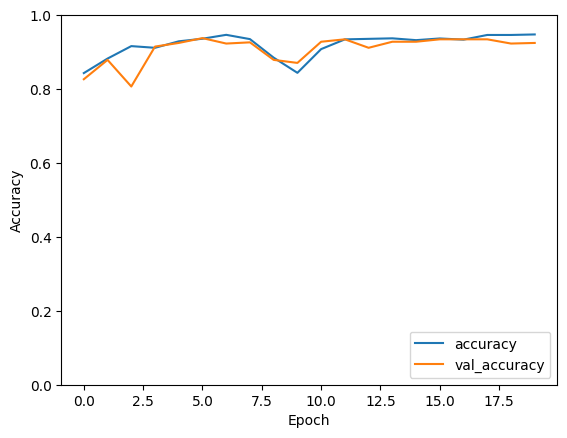

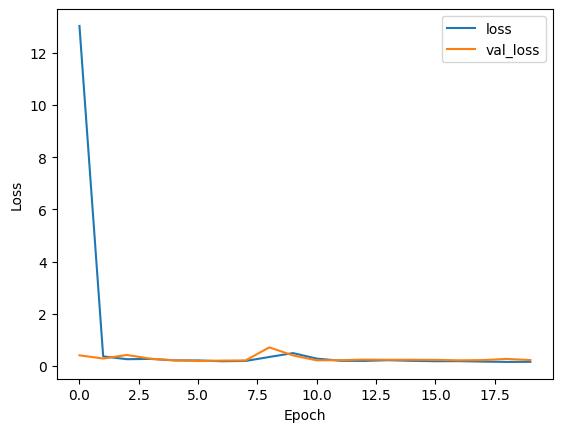

In [20]:
# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


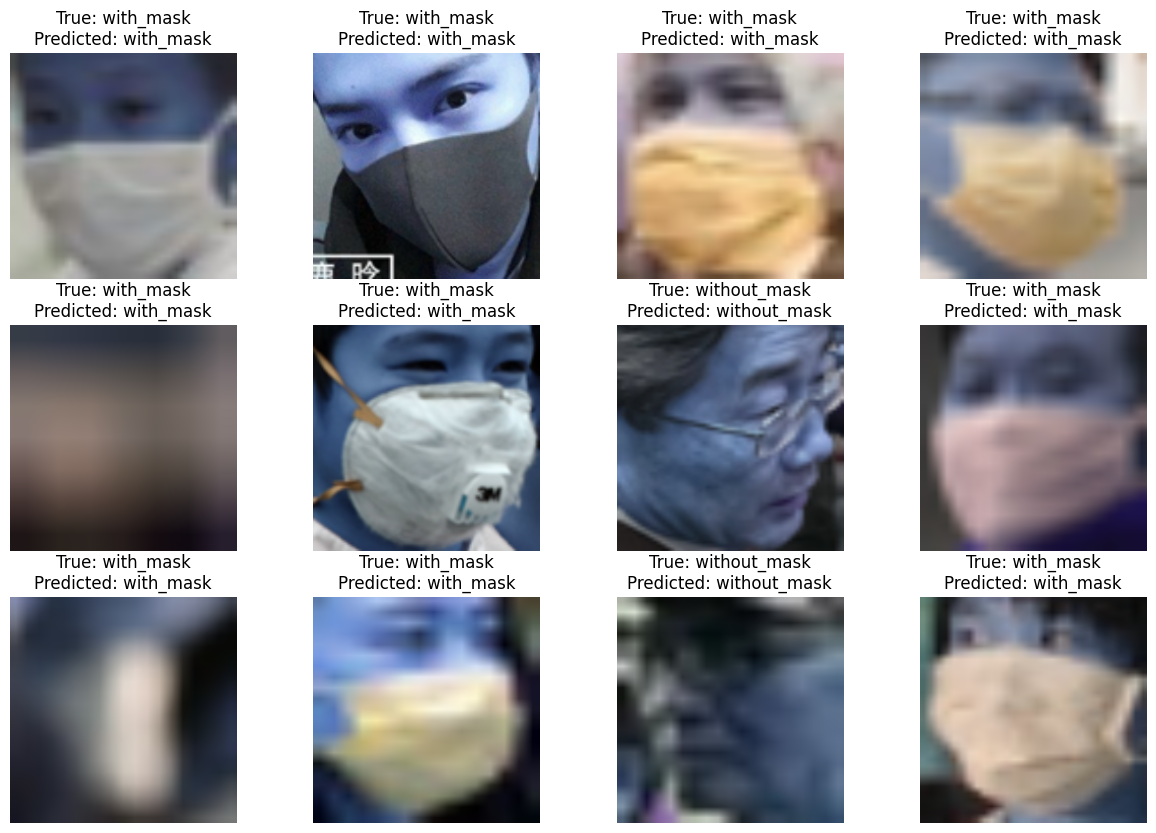

In [22]:
# Test the model with 12 images
predictions = cnn_model.predict(X_test[:12])
predicted_labels = np.argmax(predictions, axis=1)
true_labels = y_test[:12]

# Plot the test images with predicted and true labels
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"True: {label_encoder.inverse_transform([true_labels[i]])[0]}\nPredicted: {label_encoder.inverse_transform([predicted_labels[i]])[0]}")
    plt.axis('off')
plt.show()

In [ ]:
# Function to create CNN model
def create_cnn_model(num_layers, num_neurons, kernel_size, dropout_rate, regularization_type=None, normalization_type=None):
    model = models.Sequential()
    
    # Add convolutional layers
    for _ in range(num_layers):
        model.add(layers.Conv2D(32, kernel_size, activation='relu', input_shape=input_shape))
        if normalization_type == 'batch':
            model.add(layers.BatchNormalization())
        model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Flatten())
    
    # Add dense layers
    for _ in range(1):
        model.add(layers.Dense(num_neurons, activation='relu'))
        if regularization_type == 'dropout':
            model.add(layers.Dropout(dropout_rate))
        elif regularization_type == 'l2':
            model.add(layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        if normalization_type == 'batch':
            model.add(layers.BatchNormalization())
    
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Function to train and evaluate model
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=5, batch_size=32):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    return history, test_loss, test_accuracy

# Load the dataset
dataset_dir = "/kaggle/input/face-mask-detection"
X, y = load_dataset(dataset_dir)

# Preprocess labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define hyperparameters for experiments
num_layers_list = [3,4]
num_neurons_list = [64, 128, 256]
kernel_sizes_list = [(3, 3), (5, 5)]
dropout_rate_list = [0.2, 0.5]
regularization_types = [None, 'dropout', 'l2']
normalization_types = [None, 'batch']

# Perform experiments
results = []
for num_layers in num_layers_list:
    for num_neurons in num_neurons_list:
        for kernel_size in kernel_sizes_list:
            for dropout_rate in dropout_rate_list:
                for regularization_type in regularization_types:
                    for normalization_type in normalization_types:
                        print(f"Experiment: num_layers={num_layers}, num_neurons={num_neurons}, kernel_size={kernel_size}, dropout_rate={dropout_rate}, regularization_type={regularization_type}, normalization_type={normalization_type}")
                        model = create_cnn_model(num_layers, num_neurons, kernel_size, dropout_rate, regularization_type, normalization_type)
                        history, test_loss, test_accuracy = train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test)
                        results.append({
                            'num_layers': num_layers,
                            'num_neurons': num_neurons,
                            'kernel_size': kernel_size,
                            'dropout_rate': dropout_rate,
                            'regularization_type': regularization_type,
                            'normalization_type': normalization_type,
                            'test_loss': test_loss,
                            'test_accuracy': test_accuracy
                        })

# Print results
for result in results:
    print(result)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited
libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


Experiment: num_layers=3, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=None, normalization_type=None


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.7271 - loss: 26.4174 - val_accuracy: 0.9313 - val_loss: 0.2271
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9306 - loss: 0.2363 - val_accuracy: 0.9394 - val_loss: 0.2126
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9453 - loss: 0.2080 - val_accuracy: 0.9296 - val_loss: 0.1863
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9478 - loss: 0.1796 - val_accuracy: 0.9362 - val_loss: 0.1626
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9487 - loss: 0.1636 - val_accuracy: 0.9362 - val_loss: 0.1685
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9159 - loss: 0.2319
Experiment: num_layers=3, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=None, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8761 - loss: 0.4850 - val_accuracy: 0.8920 - val_loss: 0.2707
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 

W0000 00:00:1712937599.676028      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.7825 - loss: 37.0536 - val_accuracy: 0.9067 - val_loss: 0.2448
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9328 - loss: 0.2163 - val_accuracy: 0.9051 - val_loss: 0.3175
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8184 - loss: 0.5289 - val_accuracy: 0.7791 - val_loss: 0.5039
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8024 - loss: 0.4784 - val_accuracy: 0.7758 - val_loss: 0.5016
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8233 - loss: 0.4298 - val_accuracy: 0.7758 - val_loss: 0.5149
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7811 - loss: 0.5067
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=None, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8406 - loss: 0.7917

W0000 00:00:1712937623.604680      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.8413 - loss: 0.7879 - val_accuracy: 0.3224 - val_loss: 1.7622
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9499 - loss: 0.1836 - val_accuracy: 0.8691 - val_loss: 0.4124
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9562 - loss: 0.1315 - val_accuracy: 0.9362 - val_loss: 0.2027
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9665 - loss: 0.0956 - val_accuracy: 0.8985 - val_loss: 0.3175
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9633 - loss: 0.1105 - val_accuracy: 0.9362 - val_loss: 0.1928
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9303 - loss: 0.1913
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=dropout, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7782 - loss: 12.0919

W0000 00:00:1712937647.925154      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7790 - loss: 11.9958 - val_accuracy: 0.8756 - val_loss: 0.2871
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9004 - loss: 0.2605 - val_accuracy: 0.9018 - val_loss: 0.2880
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9214 - loss: 0.2410 - val_accuracy: 0.9247 - val_loss: 0.2253
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9097 - loss: 0.2339 - val_accuracy: 0.8953 - val_loss: 0.3016
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9315 - loss: 0.2007 - val_accuracy: 0.9280 - val_loss: 0.1793
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9110 - loss: 0.1992
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=dropout, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8424 - loss: 0.5549

W0000 00:00:1712937673.797218      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.8431 - loss: 0.5530 - val_accuracy: 0.9149 - val_loss: 0.2357
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9442 - loss: 0.2096 - val_accuracy: 0.9362 - val_loss: 0.2334
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9517 - loss: 0.1393 - val_accuracy: 0.8707 - val_loss: 0.3588
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9599 - loss: 0.1223 - val_accuracy: 0.9280 - val_loss: 0.2043
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9689 - loss: 0.0924 - val_accuracy: 0.9378 - val_loss: 0.1912
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9518 - loss: 0.1369
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=l2, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8188 - loss: 31.4278

W0000 00:00:1712937696.526490      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.8194 - loss: 31.1875 - val_accuracy: 0.9362 - val_loss: 1.7405
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9363 - loss: 1.6618 - val_accuracy: 0.9313 - val_loss: 1.5180
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.9440 - loss: 1.4636 - val_accuracy: 0.9378 - val_loss: 1.3748
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9528 - loss: 1.3418 - val_accuracy: 0.9182 - val_loss: 1.3121
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9438 - loss: 1.2522 - val_accuracy: 0.9444 - val_loss: 1.2427
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9460 - loss: 1.2513
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=l2, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8524 - loss: 2.6324

W0000 00:00:1712937723.584500      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.8530 - loss: 2.6270 - val_accuracy: 0.7561 - val_loss: 1.7197
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9356 - loss: 1.2468 - val_accuracy: 0.8707 - val_loss: 1.0201
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9485 - loss: 0.7344 - val_accuracy: 0.8920 - val_loss: 0.6849
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9581 - loss: 0.4938 - val_accuracy: 0.8903 - val_loss: 0.5649
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9222 - loss: 0.4876 - val_accuracy: 0.9116 - val_loss: 0.4335
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9078 - loss: 0.4373
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=None, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7557 - loss: 39.9594

W0000 00:00:1712937745.317796      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7564 - loss: 39.6552 - val_accuracy: 0.7774 - val_loss: 0.5481
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8454 - loss: 0.4239 - val_accuracy: 0.8920 - val_loss: 0.3394
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9061 - loss: 0.2423 - val_accuracy: 0.9313 - val_loss: 0.2015
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9268 - loss: 0.1949 - val_accuracy: 0.8740 - val_loss: 0.5750
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9127 - loss: 0.2471 - val_accuracy: 0.9329 - val_loss: 0.2079
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9455 - loss: 0.1868
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=None, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8548 - loss: 0.7119

W0000 00:00:1712937767.391289      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.8554 - loss: 0.7087 - val_accuracy: 0.9362 - val_loss: 0.2106
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9481 - loss: 0.1776 - val_accuracy: 0.8723 - val_loss: 0.2905
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9593 - loss: 0.1197 - val_accuracy: 0.9100 - val_loss: 0.2765
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9671 - loss: 0.1180 - val_accuracy: 0.8985 - val_loss: 0.2462
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9684 - loss: 0.1003 - val_accuracy: 0.9002 - val_loss: 0.2972
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9175 - loss: 0.2484
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=dropout, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7861 - loss: 10.5489

W0000 00:00:1712937791.419801      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.7863 - loss: 10.4687 - val_accuracy: 0.7758 - val_loss: 0.4902
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7955 - loss: 0.5125 - val_accuracy: 0.7774 - val_loss: 0.4961
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8039 - loss: 0.5096 - val_accuracy: 0.7758 - val_loss: 0.5119
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8383 - loss: 0.4169 - val_accuracy: 0.8331 - val_loss: 0.4109
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8715 - loss: 0.3737 - val_accuracy: 0.7774 - val_loss: 0.4906
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7853 - loss: 0.4834
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=dropout, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8378 - loss: 0.5252

W0000 00:00:1712937817.077938      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.8383 - loss: 0.5238 - val_accuracy: 0.9247 - val_loss: 0.2129
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9419 - loss: 0.2016 - val_accuracy: 0.8167 - val_loss: 0.5035
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9553 - loss: 0.1521 - val_accuracy: 0.9214 - val_loss: 0.1989
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9532 - loss: 0.1424 - val_accuracy: 0.9476 - val_loss: 0.1602
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9668 - loss: 0.1111 - val_accuracy: 0.9280 - val_loss: 0.2277
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9509 - loss: 0.1979
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=l2, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7620 - loss: 39.0747

W0000 00:00:1712937839.737601      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.7629 - loss: 38.7896 - val_accuracy: 0.8445 - val_loss: 1.9339
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9046 - loss: 1.5953 - val_accuracy: 0.9198 - val_loss: 1.3770
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9385 - loss: 1.3222 - val_accuracy: 0.8936 - val_loss: 1.5032
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9320 - loss: 1.2229 - val_accuracy: 0.9198 - val_loss: 1.1551
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9413 - loss: 1.0740 - val_accuracy: 0.9214 - val_loss: 1.0447
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9335 - loss: 1.0287
Experiment: num_layers=3, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=l2, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8530 - loss: 2.6270

W0000 00:00:1712937862.744150      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.8536 - loss: 2.6212 - val_accuracy: 0.8527 - val_loss: 1.5110
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9451 - loss: 1.1867 - val_accuracy: 0.9214 - val_loss: 0.8366
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9427 - loss: 0.7321 - val_accuracy: 0.7954 - val_loss: 1.1085
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9529 - loss: 0.4519 - val_accuracy: 0.9067 - val_loss: 0.5308
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9600 - loss: 0.3406 - val_accuracy: 0.7758 - val_loss: 1.3113
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7828 - loss: 1.3114
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=None, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7152 - loss: 35.5310

W0000 00:00:1712937885.699055      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7158 - loss: 35.2520 - val_accuracy: 0.7741 - val_loss: 0.5524
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8050 - loss: 0.5092 - val_accuracy: 0.7758 - val_loss: 0.5065
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8035 - loss: 0.4691 - val_accuracy: 0.7774 - val_loss: 0.5056
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8097 - loss: 0.4844 - val_accuracy: 0.7758 - val_loss: 0.5094
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7959 - loss: 0.5356 - val_accuracy: 0.7758 - val_loss: 0.5115
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7828 - loss: 0.5123
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=None, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8618 - loss: 0.7766

W0000 00:00:1712937911.712479      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.8623 - loss: 0.7729 - val_accuracy: 0.8347 - val_loss: 0.9442
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9477 - loss: 0.1984 - val_accuracy: 0.9002 - val_loss: 0.3411
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.8920 - loss: 0.3472 - val_accuracy: 0.8511 - val_loss: 0.4709
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9545 - loss: 0.1310 - val_accuracy: 0.9100 - val_loss: 0.2705
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9595 - loss: 0.1133 - val_accuracy: 0.9476 - val_loss: 0.1498
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9550 - loss: 0.1286
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=dropout, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7417 - loss: 20.1910

W0000 00:00:1712937939.892595      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7425 - loss: 20.0403 - val_accuracy: 0.9329 - val_loss: 0.2119
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9251 - loss: 0.2411 - val_accuracy: 0.9313 - val_loss: 0.1779
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9449 - loss: 0.1712 - val_accuracy: 0.9509 - val_loss: 0.1472
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9565 - loss: 0.1409 - val_accuracy: 0.9444 - val_loss: 0.1584
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9177 - loss: 0.3166 - val_accuracy: 0.9165 - val_loss: 0.2172
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9215 - loss: 0.2045
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=dropout, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8404 - loss: 0.6204

W0000 00:00:1712937969.041191      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - accuracy: 0.8410 - loss: 0.6181 - val_accuracy: 0.8953 - val_loss: 0.3350
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9464 - loss: 0.1822 - val_accuracy: 0.9198 - val_loss: 0.2214
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9503 - loss: 0.1553 - val_accuracy: 0.8003 - val_loss: 0.5031
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9543 - loss: 0.1387 - val_accuracy: 0.7921 - val_loss: 0.5924
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9572 - loss: 0.1211 - val_accuracy: 0.9378 - val_loss: 0.2000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9625 - loss: 0.1274
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=l2, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7816 - loss: 40.7462

W0000 00:00:1712938002.915365      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.7817 - loss: 40.4271 - val_accuracy: 0.7791 - val_loss: 1.9936
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8037 - loss: 1.8212 - val_accuracy: 0.7791 - val_loss: 1.6430
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8113 - loss: 1.5677 - val_accuracy: 0.7692 - val_loss: 1.4839
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8047 - loss: 1.4134 - val_accuracy: 0.7774 - val_loss: 1.3494
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8037 - loss: 1.2992 - val_accuracy: 0.7807 - val_loss: 1.2500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7867 - loss: 1.2350
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=l2, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.8590 - loss: 2.5639

W0000 00:00:1712938029.685667      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.8595 - loss: 2.5584 - val_accuracy: 0.7987 - val_loss: 1.6838
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9333 - loss: 1.1484 - val_accuracy: 0.8658 - val_loss: 0.9914
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9407 - loss: 0.6650 - val_accuracy: 0.9067 - val_loss: 0.6191
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9502 - loss: 0.4491 - val_accuracy: 0.8887 - val_loss: 0.5777
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9559 - loss: 0.3540 - val_accuracy: 0.8854 - val_loss: 0.4913
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8859 - loss: 0.4517
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=None, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7122 - loss: 67.2607

W0000 00:00:1712938054.217349      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.7126 - loss: 66.7133 - val_accuracy: 0.7758 - val_loss: 0.5981
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8133 - loss: 0.4522 - val_accuracy: 0.9427 - val_loss: 0.1616
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9290 - loss: 0.2045 - val_accuracy: 0.9460 - val_loss: 0.1443
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9595 - loss: 0.1278 - val_accuracy: 0.9460 - val_loss: 0.1318
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9617 - loss: 0.1158 - val_accuracy: 0.9362 - val_loss: 0.1457
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9537 - loss: 0.1660
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=None, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8385 - loss: 0.7820

W0000 00:00:1712938079.635013      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.8391 - loss: 0.7787 - val_accuracy: 0.8625 - val_loss: 0.5167
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9473 - loss: 0.2116 - val_accuracy: 0.7921 - val_loss: 0.5418
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9537 - loss: 0.1407 - val_accuracy: 0.9231 - val_loss: 0.2121
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9627 - loss: 0.1086 - val_accuracy: 0.9231 - val_loss: 0.1958
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9499 - loss: 0.1280 - val_accuracy: 0.9149 - val_loss: 0.2418
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9172 - loss: 0.2494
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=dropout, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7430 - loss: 32.0383

W0000 00:00:1712938106.449515      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7434 - loss: 31.7864 - val_accuracy: 0.7758 - val_loss: 0.5474
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7995 - loss: 0.5193 - val_accuracy: 0.7758 - val_loss: 0.5111
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8080 - loss: 0.4877 - val_accuracy: 0.7758 - val_loss: 0.5103
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8013 - loss: 0.4912 - val_accuracy: 0.7758 - val_loss: 0.5155
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8087 - loss: 0.4861 - val_accuracy: 0.7758 - val_loss: 0.5103
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7828 - loss: 0.5103
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=dropout, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8525 - loss: 0.5102

W0000 00:00:1712938134.987136      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.8531 - loss: 0.5085 - val_accuracy: 0.8101 - val_loss: 0.6401
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9380 - loss: 0.2126 - val_accuracy: 0.9067 - val_loss: 0.3573
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9195 - loss: 0.2297 - val_accuracy: 0.7823 - val_loss: 0.7852
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9419 - loss: 0.1619 - val_accuracy: 0.9133 - val_loss: 0.2020
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9334 - loss: 0.1762 - val_accuracy: 0.8789 - val_loss: 0.2945
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8872 - loss: 0.2911
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=l2, normalization_type=None
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7297 - loss: 18.1697

W0000 00:00:1712938159.664069      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7302 - loss: 18.0435 - val_accuracy: 0.7840 - val_loss: 1.9933
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8188 - loss: 1.8708 - val_accuracy: 0.7905 - val_loss: 1.6522
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8420 - loss: 1.5834 - val_accuracy: 0.8200 - val_loss: 1.6340
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8547 - loss: 1.4926 - val_accuracy: 0.9067 - val_loss: 1.3578
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9202 - loss: 1.3001 - val_accuracy: 0.9133 - val_loss: 1.2321
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9179 - loss: 1.2513
Experiment: num_layers=3, num_neurons=256, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=l2, normalization_type=batch
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8486 - loss: 2.5867

W0000 00:00:1712938185.240383      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 76ms/step - accuracy: 0.8492 - loss: 2.5813 - val_accuracy: 0.4157 - val_loss: 2.5591
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9327 - loss: 1.1978 - val_accuracy: 0.9345 - val_loss: 0.8632
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9265 - loss: 0.7958 - val_accuracy: 0.9345 - val_loss: 0.5919
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9364 - loss: 0.5461 - val_accuracy: 0.9165 - val_loss: 0.5635
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9414 - loss: 0.4207 - val_accuracy: 0.9067 - val_loss: 0.4181
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8867 - loss: 0.4534
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=None, normalization_type=None
Epoch 1/5
 7/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5802 - loss: 20.2397

W0000 00:00:1712938207.250376      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7322 - loss: 5.5443

W0000 00:00:1712938211.879910      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7333 - loss: 5.5030 - val_accuracy: 0.9345 - val_loss: 0.2279
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9302 - loss: 0.2116 - val_accuracy: 0.9214 - val_loss: 0.2991
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9465 - loss: 0.1892 - val_accuracy: 0.9444 - val_loss: 0.1584
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9617 - loss: 0.1304 - val_accuracy: 0.9460 - val_loss: 0.1527
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9559 - loss: 0.1560 - val_accuracy: 0.9460 - val_loss: 0.1717
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9567 - loss: 0.1622
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=None, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5069 - loss: 0.9841

W0000 00:00:1712938229.945476      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8312 - loss: 0.4694

W0000 00:00:1712938236.415732      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.8319 - loss: 0.4680 - val_accuracy: 0.7872 - val_loss: 0.4550
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9564 - loss: 0.1666 - val_accuracy: 0.9051 - val_loss: 0.3148
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9473 - loss: 0.1477 - val_accuracy: 0.8773 - val_loss: 0.3925
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9607 - loss: 0.1116 - val_accuracy: 0.9313 - val_loss: 0.2006
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9629 - loss: 0.1077 - val_accuracy: 0.9280 - val_loss: 0.2943
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9353 - loss: 0.2399
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=dropout, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5011 - loss: 12.4143

W0000 00:00:1712938255.442080      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7499 - loss: 2.7893

W0000 00:00:1712938260.774410      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7509 - loss: 2.7691 - val_accuracy: 0.9362 - val_loss: 0.2107
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9271 - loss: 0.2121 - val_accuracy: 0.9034 - val_loss: 0.2663
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9145 - loss: 0.2412 - val_accuracy: 0.9444 - val_loss: 0.1566
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9444 - loss: 0.1837 - val_accuracy: 0.9247 - val_loss: 0.1793
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8955 - loss: 0.2191 - val_accuracy: 0.9444 - val_loss: 0.1569
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9291 - loss: 0.1665
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=dropout, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.4722 - loss: 1.0236 

W0000 00:00:1712938279.959838      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8118 - loss: 0.4833

W0000 00:00:1712938287.746568      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.8126 - loss: 0.4818 - val_accuracy: 0.8560 - val_loss: 0.3099
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9404 - loss: 0.2100 - val_accuracy: 0.8085 - val_loss: 0.4218
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9549 - loss: 0.1554 - val_accuracy: 0.8822 - val_loss: 0.2734
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9478 - loss: 0.1697 - val_accuracy: 0.8167 - val_loss: 0.4285
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9529 - loss: 0.1440 - val_accuracy: 0.9231 - val_loss: 0.2062
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9147 - loss: 0.2053
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=l2, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4934 - loss: 4.5894

W0000 00:00:1712938306.647383      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8216 - loss: 1.5358

W0000 00:00:1712938311.326872      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.8224 - loss: 1.5291 - val_accuracy: 0.9394 - val_loss: 0.5723
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9305 - loss: 0.5700 - val_accuracy: 0.9411 - val_loss: 0.4468
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9499 - loss: 0.4473 - val_accuracy: 0.9378 - val_loss: 0.4054
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9468 - loss: 0.3888 - val_accuracy: 0.9378 - val_loss: 0.3564
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9518 - loss: 0.3446 - val_accuracy: 0.9509 - val_loss: 0.3190
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9481 - loss: 0.3005
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=l2, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4549 - loss: 1.6184

W0000 00:00:1712938329.895226      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8003 - loss: 1.0467

W0000 00:00:1712938336.668759      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.8012 - loss: 1.0446 - val_accuracy: 0.8183 - val_loss: 0.7786
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9472 - loss: 0.5592 - val_accuracy: 0.8511 - val_loss: 0.5780
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9520 - loss: 0.4021 - val_accuracy: 0.9198 - val_loss: 0.3825
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9413 - loss: 0.3324 - val_accuracy: 0.9313 - val_loss: 0.3279
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9508 - loss: 0.2813 - val_accuracy: 0.8298 - val_loss: 0.6690
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8512 - loss: 0.6312
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=None, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6056 - loss: 27.1770

W0000 00:00:1712938354.267496      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8151 - loss: 5.6144

W0000 00:00:1712938358.322152      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.8161 - loss: 5.5704 - val_accuracy: 0.9378 - val_loss: 0.2040
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9444 - loss: 0.1804 - val_accuracy: 0.9460 - val_loss: 0.1461
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9501 - loss: 0.1508 - val_accuracy: 0.9509 - val_loss: 0.1416
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9491 - loss: 0.1600 - val_accuracy: 0.9493 - val_loss: 0.1375
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9483 - loss: 0.1569 - val_accuracy: 0.9493 - val_loss: 0.1431
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9570 - loss: 0.1528
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=None, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6215 - loss: 1.1546

W0000 00:00:1712938378.105863      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8626 - loss: 0.4985

W0000 00:00:1712938383.922886      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8631 - loss: 0.4970 - val_accuracy: 0.8511 - val_loss: 0.3856
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9543 - loss: 0.1875 - val_accuracy: 0.9362 - val_loss: 0.2502
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9441 - loss: 0.1658 - val_accuracy: 0.9247 - val_loss: 0.2817
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9678 - loss: 0.1099 - val_accuracy: 0.8903 - val_loss: 0.3037
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9711 - loss: 0.0941 - val_accuracy: 0.9509 - val_loss: 0.1800
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9553 - loss: 0.1414
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=dropout, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6255 - loss: 27.1521

W0000 00:00:1712938403.607658      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8161 - loss: 4.9952

W0000 00:00:1712938408.990511      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8167 - loss: 4.9562 - val_accuracy: 0.9394 - val_loss: 0.1749
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9373 - loss: 0.2126 - val_accuracy: 0.9280 - val_loss: 0.1659
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9392 - loss: 0.1957 - val_accuracy: 0.9444 - val_loss: 0.1525
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9429 - loss: 0.1994 - val_accuracy: 0.9378 - val_loss: 0.1515
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9387 - loss: 0.2098 - val_accuracy: 0.9296 - val_loss: 0.1838
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9543 - loss: 0.1778
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=dropout, normalization_type=batch
Epoch 1/5
 4/90 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5449 - loss: 1.0235

W0000 00:00:1712938428.484822      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8361 - loss: 0.5044

W0000 00:00:1712938436.229303      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.8367 - loss: 0.5030 - val_accuracy: 0.9394 - val_loss: 0.2256
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9212 - loss: 0.2544 - val_accuracy: 0.9378 - val_loss: 0.2035
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9462 - loss: 0.1719 - val_accuracy: 0.9493 - val_loss: 0.1712
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9402 - loss: 0.1656 - val_accuracy: 0.9525 - val_loss: 0.1651
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9386 - loss: 0.1883 - val_accuracy: 0.9018 - val_loss: 0.2370
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8986 - loss: 0.2252
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=l2, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.6489 - loss: 5.6745

W0000 00:00:1712938454.167047      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8572 - loss: 1.6842

W0000 00:00:1712938458.531297      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8577 - loss: 1.6765 - val_accuracy: 0.9264 - val_loss: 0.6513
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9126 - loss: 0.6305 - val_accuracy: 0.9394 - val_loss: 0.5169
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9445 - loss: 0.4978 - val_accuracy: 0.9476 - val_loss: 0.4282
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9562 - loss: 0.4145 - val_accuracy: 0.8789 - val_loss: 0.6003
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9414 - loss: 0.4004 - val_accuracy: 0.9460 - val_loss: 0.3372
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9539 - loss: 0.3485
Experiment: num_layers=4, num_neurons=64, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=l2, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5122 - loss: 1.4546

W0000 00:00:1712938477.290496      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8224 - loss: 1.0398

W0000 00:00:1712938483.393760      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.8232 - loss: 1.0378 - val_accuracy: 0.4206 - val_loss: 1.2063
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9425 - loss: 0.5566 - val_accuracy: 0.9296 - val_loss: 0.5315
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9540 - loss: 0.3928 - val_accuracy: 0.8429 - val_loss: 0.5644
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9657 - loss: 0.2971 - val_accuracy: 0.8249 - val_loss: 0.5486
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9487 - loss: 0.2766 - val_accuracy: 0.9100 - val_loss: 0.3334
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9228 - loss: 0.3149
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=None, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6649 - loss: 19.9209

W0000 00:00:1712938501.821782      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7668 - loss: 3.9727

W0000 00:00:1712938506.983144      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.7674 - loss: 3.9429 - val_accuracy: 0.8478 - val_loss: 0.3594
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9206 - loss: 0.2373 - val_accuracy: 0.7971 - val_loss: 0.4585
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8406 - loss: 0.3619 - val_accuracy: 0.8494 - val_loss: 0.6022
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8975 - loss: 0.2980 - val_accuracy: 0.6334 - val_loss: 0.5985
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5954 - loss: 0.6510 - val_accuracy: 0.8298 - val_loss: 0.2710
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8453 - loss: 0.2626
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=None, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5694 - loss: 0.8597

W0000 00:00:1712938527.417395      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8464 - loss: 0.4356

W0000 00:00:1712938534.523471      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.8470 - loss: 0.4345 - val_accuracy: 0.5319 - val_loss: 1.3579
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9438 - loss: 0.2192 - val_accuracy: 0.9149 - val_loss: 0.2404
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9413 - loss: 0.1764 - val_accuracy: 0.9427 - val_loss: 0.2378
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9513 - loss: 0.1389 - val_accuracy: 0.8887 - val_loss: 0.2799
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9560 - loss: 0.1276 - val_accuracy: 0.9100 - val_loss: 0.2591
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9125 - loss: 0.2600
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=dropout, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5903 - loss: 4.0773

W0000 00:00:1712938555.667659      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7974 - loss: 0.9506

W0000 00:00:1712938561.605831      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7980 - loss: 0.9452 - val_accuracy: 0.9083 - val_loss: 0.2492
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9336 - loss: 0.2089 - val_accuracy: 0.8969 - val_loss: 0.2300
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9315 - loss: 0.1795 - val_accuracy: 0.9018 - val_loss: 0.2153
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9281 - loss: 0.2029 - val_accuracy: 0.9133 - val_loss: 0.1759
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9323 - loss: 0.2024 - val_accuracy: 0.9427 - val_loss: 0.1624
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9441 - loss: 0.1548
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=dropout, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6198 - loss: 0.7933

W0000 00:00:1712938583.180928      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8319 - loss: 0.4908

W0000 00:00:1712938591.541658      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.8325 - loss: 0.4894 - val_accuracy: 0.7921 - val_loss: 0.7338
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9327 - loss: 0.2376 - val_accuracy: 0.8740 - val_loss: 0.2737
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9419 - loss: 0.1995 - val_accuracy: 0.5499 - val_loss: 1.7031
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9379 - loss: 0.1867 - val_accuracy: 0.9296 - val_loss: 0.1852
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9416 - loss: 0.1602 - val_accuracy: 0.9231 - val_loss: 0.2019
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9049 - loss: 0.2018 
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=l2, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6250 - loss: 4.8409

W0000 00:00:1712938612.735474      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7663 - loss: 1.5441

W0000 00:00:1712938617.943029      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.7667 - loss: 1.5384 - val_accuracy: 0.9034 - val_loss: 0.6392
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9036 - loss: 0.6173 - val_accuracy: 0.8903 - val_loss: 0.4957
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9252 - loss: 0.4619 - val_accuracy: 0.9313 - val_loss: 0.3815
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9328 - loss: 0.4017 - val_accuracy: 0.9264 - val_loss: 0.5193
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9054 - loss: 0.4254 - val_accuracy: 0.9394 - val_loss: 0.3179
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9537 - loss: 0.2996
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=l2, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5625 - loss: 1.4427

W0000 00:00:1712938638.630655      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8383 - loss: 1.0330

W0000 00:00:1712938646.051314      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.8390 - loss: 1.0311 - val_accuracy: 0.8478 - val_loss: 0.8296
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9401 - loss: 0.6316 - val_accuracy: 0.9165 - val_loss: 0.5578
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9549 - loss: 0.4493 - val_accuracy: 0.8642 - val_loss: 0.5779
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9459 - loss: 0.3883 - val_accuracy: 0.9264 - val_loss: 0.3902
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9570 - loss: 0.3065 - val_accuracy: 0.8314 - val_loss: 0.5858
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8391 - loss: 0.5789 
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=None, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.5243 - loss: 34.8014

W0000 00:00:1712938675.670932      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7319 - loss: 5.7847

W0000 00:00:1712938680.293961      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7327 - loss: 5.7398 - val_accuracy: 0.8511 - val_loss: 0.4344
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9064 - loss: 0.2952 - val_accuracy: 0.9427 - val_loss: 0.1813
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9416 - loss: 0.1722 - val_accuracy: 0.9182 - val_loss: 0.1921
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9475 - loss: 0.1534 - val_accuracy: 0.9411 - val_loss: 0.1519
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9415 - loss: 0.1601 - val_accuracy: 0.9411 - val_loss: 0.1423
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9486 - loss: 0.1410
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=None, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.4878 - loss: 1.0968

W0000 00:00:1712938700.552240      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8048 - loss: 0.5524

W0000 00:00:1712938706.894985      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - accuracy: 0.8057 - loss: 0.5504 - val_accuracy: 0.7758 - val_loss: 1.0325
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9381 - loss: 0.2009 - val_accuracy: 0.8576 - val_loss: 0.3859
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9460 - loss: 0.1776 - val_accuracy: 0.9394 - val_loss: 0.1821
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9465 - loss: 0.1542 - val_accuracy: 0.9444 - val_loss: 0.1914
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9587 - loss: 0.1187 - val_accuracy: 0.8871 - val_loss: 0.2878
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9127 - loss: 0.2427 
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=dropout, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4497 - loss: 10.1734

W0000 00:00:1712938727.933948      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7549 - loss: 2.0335

W0000 00:00:1712938733.921335      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7557 - loss: 2.0203 - val_accuracy: 0.8756 - val_loss: 0.2485
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8273 - loss: 0.3069 - val_accuracy: 0.9149 - val_loss: 0.2240
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9040 - loss: 0.2548 - val_accuracy: 0.8871 - val_loss: 0.2554
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9217 - loss: 0.2225 - val_accuracy: 0.9427 - val_loss: 0.2296
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9379 - loss: 0.2059 - val_accuracy: 0.9476 - val_loss: 0.1440
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9313 - loss: 0.1739
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=dropout, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.6128 - loss: 0.7831

W0000 00:00:1712938755.456474      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8222 - loss: 0.4978

W0000 00:00:1712938763.917996      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8228 - loss: 0.4967 - val_accuracy: 0.9100 - val_loss: 0.3710
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9288 - loss: 0.2688 - val_accuracy: 0.8953 - val_loss: 0.3148
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9335 - loss: 0.2377 - val_accuracy: 0.8576 - val_loss: 0.4008
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9307 - loss: 0.2263 - val_accuracy: 0.9165 - val_loss: 0.2072
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9438 - loss: 0.1751 - val_accuracy: 0.9313 - val_loss: 0.2117
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9399 - loss: 0.1953 
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=l2, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.3767 - loss: 9.2409

W0000 00:00:1712938784.064582      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7442 - loss: 2.4111

W0000 00:00:1712938788.833350      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - accuracy: 0.7449 - loss: 2.3985 - val_accuracy: 0.8543 - val_loss: 0.7432
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8878 - loss: 0.6763 - val_accuracy: 0.9100 - val_loss: 0.5824
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9220 - loss: 0.5509 - val_accuracy: 0.9280 - val_loss: 0.4890
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9395 - loss: 0.4517 - val_accuracy: 0.8167 - val_loss: 0.6826
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8369 - loss: 0.8977 - val_accuracy: 0.7725 - val_loss: 0.8464
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7828 - loss: 0.8432 
Experiment: num_layers=4, num_neurons=64, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=l2, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.4688 - loss: 1.6286

W0000 00:00:1712938809.454014      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8161 - loss: 1.0470

W0000 00:00:1712938816.043333      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8170 - loss: 1.0450 - val_accuracy: 0.8036 - val_loss: 0.8045
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9355 - loss: 0.5550 - val_accuracy: 0.8151 - val_loss: 0.7839
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9296 - loss: 0.4716 - val_accuracy: 0.7774 - val_loss: 0.8769
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9342 - loss: 0.4054 - val_accuracy: 0.9394 - val_loss: 0.3403
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9444 - loss: 0.3097 - val_accuracy: 0.8969 - val_loss: 0.3790
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9258 - loss: 0.3940
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=None, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6033 - loss: 13.3657

W0000 00:00:1712938836.165273      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7992 - loss: 4.0988

W0000 00:00:1712938839.896422      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712938840.700991      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.8001 - loss: 4.0688 - val_accuracy: 0.9394 - val_loss: 0.1729
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9480 - loss: 0.1670 - val_accuracy: 0.9378 - val_loss: 0.2226
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9593 - loss: 0.1380 - val_accuracy: 0.9427 - val_loss: 0.1635
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9347 - loss: 0.2314 - val_accuracy: 0.8543 - val_loss: 0.2864
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8771 - loss: 0.3289 - val_accuracy: 0.9198 - val_loss: 0.2529
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9343 - loss: 0.1954
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=None, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5365 - loss: 0.9334

W0000 00:00:1712938858.954983      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8410 - loss: 0.4776

W0000 00:00:1712938864.561007      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712938865.519057      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8417 - loss: 0.4758 - val_accuracy: 0.8347 - val_loss: 0.3938
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9454 - loss: 0.1869 - val_accuracy: 0.8576 - val_loss: 0.3854
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9403 - loss: 0.2022 - val_accuracy: 0.9476 - val_loss: 0.2034
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9429 - loss: 0.1848 - val_accuracy: 0.8380 - val_loss: 0.4797
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9578 - loss: 0.1296 - val_accuracy: 0.9378 - val_loss: 0.1727
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9362 - loss: 0.1661
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=dropout, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6080 - loss: 19.8109

W0000 00:00:1712938884.499762      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8013 - loss: 5.6195

W0000 00:00:1712938889.208669      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712938889.888076      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8022 - loss: 5.5778 - val_accuracy: 0.9378 - val_loss: 0.1801
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9155 - loss: 0.2860 - val_accuracy: 0.9264 - val_loss: 0.1950
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9294 - loss: 0.2124 - val_accuracy: 0.9083 - val_loss: 0.2506
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9441 - loss: 0.1876 - val_accuracy: 0.7971 - val_loss: 0.4293
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8114 - loss: 0.3967 - val_accuracy: 0.8674 - val_loss: 0.4343
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8797 - loss: 0.3800
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=dropout, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5816 - loss: 0.8240 

W0000 00:00:1712938911.365884      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8469 - loss: 0.4560

W0000 00:00:1712938918.341778      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712938919.809447      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.8476 - loss: 0.4545 - val_accuracy: 0.7823 - val_loss: 0.7260
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9379 - loss: 0.2067 - val_accuracy: 0.9165 - val_loss: 0.2118
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9435 - loss: 0.1827 - val_accuracy: 0.9378 - val_loss: 0.1912
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9642 - loss: 0.1131 - val_accuracy: 0.9542 - val_loss: 0.1866
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9731 - loss: 0.0907 - val_accuracy: 0.8298 - val_loss: 0.4294
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8601 - loss: 0.4364
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=l2, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5706 - loss: 31.0818

W0000 00:00:1712938938.165730      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8131 - loss: 6.0099

W0000 00:00:1712938941.977673      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712938942.833016      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8139 - loss: 5.9691 - val_accuracy: 0.8412 - val_loss: 1.1169
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9223 - loss: 0.9366 - val_accuracy: 0.9378 - val_loss: 0.7850
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9380 - loss: 0.7985 - val_accuracy: 0.9411 - val_loss: 0.7264
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9431 - loss: 0.7151 - val_accuracy: 0.9460 - val_loss: 0.6630
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9420 - loss: 0.6770 - val_accuracy: 0.9394 - val_loss: 0.6351
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9517 - loss: 0.6391
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=l2, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6302 - loss: 2.2138

W0000 00:00:1712938961.521630      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.8472 - loss: 1.5605

W0000 00:00:1712938967.220929      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712938968.227887      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.8479 - loss: 1.5575 - val_accuracy: 0.8003 - val_loss: 1.1584
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9359 - loss: 0.8376 - val_accuracy: 0.9051 - val_loss: 0.6899
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9514 - loss: 0.5517 - val_accuracy: 0.9100 - val_loss: 0.5804
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9549 - loss: 0.4158 - val_accuracy: 0.9149 - val_loss: 0.4880
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9411 - loss: 0.3821 - val_accuracy: 0.8822 - val_loss: 0.5277
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8847 - loss: 0.5282
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=None, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6052 - loss: 51.5465

W0000 00:00:1712938985.809373      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7996 - loss: 10.0931

W0000 00:00:1712938989.213487      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712938989.931946      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8005 - loss: 10.0125 - val_accuracy: 0.9394 - val_loss: 0.1713
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9509 - loss: 0.1674 - val_accuracy: 0.9083 - val_loss: 0.2061
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9419 - loss: 0.1818 - val_accuracy: 0.9329 - val_loss: 0.1703
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9403 - loss: 0.1580 - val_accuracy: 0.9214 - val_loss: 0.2159
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9558 - loss: 0.1135 - val_accuracy: 0.9378 - val_loss: 0.1488
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9433 - loss: 0.1494
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=None, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5764 - loss: 0.8767

W0000 00:00:1712939007.317271      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8493 - loss: 0.4770

W0000 00:00:1712939012.364852      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939013.848213      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.8499 - loss: 0.4757 - val_accuracy: 0.7987 - val_loss: 0.4707
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9349 - loss: 0.2076 - val_accuracy: 0.9411 - val_loss: 0.1681
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9611 - loss: 0.1317 - val_accuracy: 0.8707 - val_loss: 0.2642
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9535 - loss: 0.1154 - val_accuracy: 0.9116 - val_loss: 0.2472
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9678 - loss: 0.1124 - val_accuracy: 0.9345 - val_loss: 0.2059
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9147 - loss: 0.2109
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=dropout, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4852 - loss: 24.7118

W0000 00:00:1712939032.905524      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7706 - loss: 5.1860

W0000 00:00:1712939037.584144      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939038.287422      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.7716 - loss: 5.1461 - val_accuracy: 0.9394 - val_loss: 0.1563
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9327 - loss: 0.2042 - val_accuracy: 0.9394 - val_loss: 0.1469
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9285 - loss: 0.2112 - val_accuracy: 0.8969 - val_loss: 0.2747
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8949 - loss: 0.2630 - val_accuracy: 0.9509 - val_loss: 0.1357
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9376 - loss: 0.1931 - val_accuracy: 0.9100 - val_loss: 0.1926
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9270 - loss: 0.2107
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=dropout, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6042 - loss: 0.9382 

W0000 00:00:1712939057.925067      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8410 - loss: 0.4795

W0000 00:00:1712939064.959167      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939065.789427      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - accuracy: 0.8415 - loss: 0.4782 - val_accuracy: 0.7807 - val_loss: 0.4679
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9341 - loss: 0.2218 - val_accuracy: 0.9476 - val_loss: 0.2098
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9394 - loss: 0.1869 - val_accuracy: 0.9264 - val_loss: 0.2266
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9434 - loss: 0.1551 - val_accuracy: 0.9264 - val_loss: 0.2132
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9538 - loss: 0.1434 - val_accuracy: 0.9427 - val_loss: 0.1661
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9516 - loss: 0.1456
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=l2, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.7574 - loss: 13.3190

W0000 00:00:1712939083.763639      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7707 - loss: 4.2766

W0000 00:00:1712939087.327058      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939088.061527      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7714 - loss: 4.2523 - val_accuracy: 0.9247 - val_loss: 1.0043
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9172 - loss: 0.9188 - val_accuracy: 0.8560 - val_loss: 0.8622
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9156 - loss: 0.7527 - val_accuracy: 0.9378 - val_loss: 0.6491
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9434 - loss: 0.6431 - val_accuracy: 0.9460 - val_loss: 0.5861
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9322 - loss: 0.6250 - val_accuracy: 0.9394 - val_loss: 0.5344
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9388 - loss: 0.5669
Experiment: num_layers=4, num_neurons=128, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=l2, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5799 - loss: 2.0624

W0000 00:00:1712939106.007874      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8418 - loss: 1.5181

W0000 00:00:1712939111.204818      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939112.067819      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.8424 - loss: 1.5152 - val_accuracy: 0.7938 - val_loss: 1.1590
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9433 - loss: 0.7842 - val_accuracy: 0.7349 - val_loss: 0.9188
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9505 - loss: 0.5138 - val_accuracy: 0.9182 - val_loss: 0.5287
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9473 - loss: 0.3823 - val_accuracy: 0.9411 - val_loss: 0.3563
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9498 - loss: 0.3069 - val_accuracy: 0.9509 - val_loss: 0.3121
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9425 - loss: 0.3018
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=None, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5100 - loss: 28.8730

W0000 00:00:1712939130.924217      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7182 - loss: 6.0118

W0000 00:00:1712939135.250736      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939136.059369      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.7192 - loss: 5.9660 - val_accuracy: 0.9214 - val_loss: 0.2235
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9287 - loss: 0.2196 - val_accuracy: 0.9296 - val_loss: 0.1913
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9235 - loss: 0.2213 - val_accuracy: 0.9362 - val_loss: 0.1888
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9429 - loss: 0.1762 - val_accuracy: 0.9362 - val_loss: 0.2387
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9413 - loss: 0.1757 - val_accuracy: 0.9394 - val_loss: 0.1506
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9406 - loss: 0.1567
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=None, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.4479 - loss: 1.1326

W0000 00:00:1712939156.500774      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8381 - loss: 0.5238

W0000 00:00:1712939162.680322      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939163.636686      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.8388 - loss: 0.5220 - val_accuracy: 0.4092 - val_loss: 1.7522
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9301 - loss: 0.2433 - val_accuracy: 0.9100 - val_loss: 0.2699
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9426 - loss: 0.1673 - val_accuracy: 0.7758 - val_loss: 1.2004
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9433 - loss: 0.1475 - val_accuracy: 0.8674 - val_loss: 0.3022
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9374 - loss: 0.1659 - val_accuracy: 0.9444 - val_loss: 0.1716
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9401 - loss: 0.1876 
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=dropout, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5104 - loss: 29.7477

W0000 00:00:1712939184.959890      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7418 - loss: 5.4805

W0000 00:00:1712939190.301020      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939191.032157      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7423 - loss: 5.4387 - val_accuracy: 0.8511 - val_loss: 0.3231
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8631 - loss: 0.3114 - val_accuracy: 0.9296 - val_loss: 0.2300
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8918 - loss: 0.2484 - val_accuracy: 0.9018 - val_loss: 0.2222
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9011 - loss: 0.2613 - val_accuracy: 0.8314 - val_loss: 0.3084
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9193 - loss: 0.2244 - val_accuracy: 0.9329 - val_loss: 0.1637
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9414 - loss: 0.1569
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=dropout, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5486 - loss: 0.9636

W0000 00:00:1712939212.668194      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8363 - loss: 0.5268

W0000 00:00:1712939220.313393      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939221.173648      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.8369 - loss: 0.5254 - val_accuracy: 0.9198 - val_loss: 0.2597
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9347 - loss: 0.2339 - val_accuracy: 0.9198 - val_loss: 0.3135
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9444 - loss: 0.1735 - val_accuracy: 0.9296 - val_loss: 0.2129
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9494 - loss: 0.1586 - val_accuracy: 0.9313 - val_loss: 0.1940
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9506 - loss: 0.1505 - val_accuracy: 0.8200 - val_loss: 0.5997
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8134 - loss: 0.6138 
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=l2, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4392 - loss: 30.6134

W0000 00:00:1712939242.448810      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8063 - loss: 6.0916

W0000 00:00:1712939246.908843      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939247.779365      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.8072 - loss: 6.0507 - val_accuracy: 0.8445 - val_loss: 1.0284
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8403 - loss: 1.0209 - val_accuracy: 0.8953 - val_loss: 0.8236
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9156 - loss: 0.7797 - val_accuracy: 0.8903 - val_loss: 0.7565
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8828 - loss: 0.8051 - val_accuracy: 0.9411 - val_loss: 0.6541
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9443 - loss: 0.6589 - val_accuracy: 0.9247 - val_loss: 0.6414
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9221 - loss: 0.6277
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.2, regularization_type=l2, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.5538 - loss: 2.2025

W0000 00:00:1712939268.671978      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8426 - loss: 1.5779

W0000 00:00:1712939275.032411      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939276.031144      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.8433 - loss: 1.5750 - val_accuracy: 0.8609 - val_loss: 1.1239
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9326 - loss: 0.8664 - val_accuracy: 0.8396 - val_loss: 0.7505
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9252 - loss: 0.6469 - val_accuracy: 0.8707 - val_loss: 0.6260
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9337 - loss: 0.4748 - val_accuracy: 0.8396 - val_loss: 0.6874
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9421 - loss: 0.3781 - val_accuracy: 0.8658 - val_loss: 0.4973
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8842 - loss: 0.4592
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=None, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6337 - loss: 19.1396

W0000 00:00:1712939295.906074      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7720 - loss: 3.5033

W0000 00:00:1712939299.887276      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939300.615299      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.7725 - loss: 3.4773 - val_accuracy: 0.8658 - val_loss: 0.3253
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8764 - loss: 0.2724 - val_accuracy: 0.8887 - val_loss: 0.2794
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9031 - loss: 0.2334 - val_accuracy: 0.9002 - val_loss: 0.2576
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8907 - loss: 0.2825 - val_accuracy: 0.8871 - val_loss: 0.3133
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8999 - loss: 0.2386 - val_accuracy: 0.9264 - val_loss: 0.2104
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9308 - loss: 0.2095
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=None, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5434 - loss: 1.0090

W0000 00:00:1712939320.153951      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8397 - loss: 0.5311

W0000 00:00:1712939325.738787      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939326.561315      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.8404 - loss: 0.5294 - val_accuracy: 0.9083 - val_loss: 0.2865
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9248 - loss: 0.2362 - val_accuracy: 0.9133 - val_loss: 0.3150
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9323 - loss: 0.1965 - val_accuracy: 0.9394 - val_loss: 0.2242
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9542 - loss: 0.1324 - val_accuracy: 0.9083 - val_loss: 0.2251
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9510 - loss: 0.1277 - val_accuracy: 0.9149 - val_loss: 0.2703
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9003 - loss: 0.2635 
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=dropout, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5712 - loss: 14.5552

W0000 00:00:1712939348.444772      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7733 - loss: 2.8115

W0000 00:00:1712939353.767253      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939354.477185      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.7740 - loss: 2.7914 - val_accuracy: 0.7250 - val_loss: 0.5075
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7228 - loss: 0.5273 - val_accuracy: 0.7758 - val_loss: 0.5546
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7971 - loss: 0.4917 - val_accuracy: 0.7758 - val_loss: 0.4047
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8079 - loss: 0.2868 - val_accuracy: 0.8036 - val_loss: 0.2703
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8207 - loss: 0.3682 - val_accuracy: 0.7774 - val_loss: 0.3378
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7812 - loss: 0.3170
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=dropout, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5399 - loss: 1.0859

W0000 00:00:1712939376.235500      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7772 - loss: 0.6235

W0000 00:00:1712939383.841674      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939384.680995      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.7780 - loss: 0.6217 - val_accuracy: 0.8527 - val_loss: 0.7803
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9189 - loss: 0.2705 - val_accuracy: 0.9444 - val_loss: 0.1808
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9371 - loss: 0.2177 - val_accuracy: 0.8838 - val_loss: 0.3007
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9299 - loss: 0.2013 - val_accuracy: 0.9067 - val_loss: 0.3207
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9290 - loss: 0.1949 - val_accuracy: 0.9002 - val_loss: 0.2456
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9031 - loss: 0.2566
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=l2, normalization_type=None
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.4549 - loss: 17.2561

W0000 00:00:1712939405.024423      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7460 - loss: 3.8879

W0000 00:00:1712939409.107619      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939409.852359      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.7470 - loss: 3.8663 - val_accuracy: 0.8953 - val_loss: 1.0554
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9179 - loss: 0.9887 - val_accuracy: 0.9362 - val_loss: 0.7983
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9273 - loss: 0.7780 - val_accuracy: 0.9313 - val_loss: 0.7147
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9385 - loss: 0.6972 - val_accuracy: 0.7971 - val_loss: 0.8222
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8999 - loss: 0.7348 - val_accuracy: 0.9394 - val_loss: 0.5843
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9566 - loss: 0.5974
Experiment: num_layers=4, num_neurons=128, kernel_size=(5, 5), dropout_rate=0.5, regularization_type=l2, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5833 - loss: 2.0836

W0000 00:00:1712939429.865791      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8558 - loss: 1.5551

W0000 00:00:1712939435.545859      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939436.432222      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.8563 - loss: 1.5524 - val_accuracy: 0.8282 - val_loss: 1.2282
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9366 - loss: 0.8639 - val_accuracy: 0.8069 - val_loss: 1.1752
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9297 - loss: 0.6159 - val_accuracy: 0.8396 - val_loss: 0.8976
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9539 - loss: 0.4354 - val_accuracy: 0.8707 - val_loss: 0.5590
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9534 - loss: 0.3479 - val_accuracy: 0.9067 - val_loss: 0.3922
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8878 - loss: 0.3967 
Experiment: num_layers=4, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=None, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4917 - loss: 45.9268

W0000 00:00:1712939457.412614      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7868 - loss: 9.1588

W0000 00:00:1712939461.237857      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939462.053938      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7879 - loss: 9.0857 - val_accuracy: 0.9378 - val_loss: 0.1537
Epoch 2/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9379 - loss: 0.2667

W0000 00:00:1712939462.645376      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9235 - loss: 0.2289 - val_accuracy: 0.9034 - val_loss: 0.2725
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9223 - loss: 0.2287 - val_accuracy: 0.9378 - val_loss: 0.1496
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9473 - loss: 0.1668 - val_accuracy: 0.9460 - val_loss: 0.1664
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9264 - loss: 0.2306 - val_accuracy: 0.9133 - val_loss: 0.2043
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9319 - loss: 0.1777
Experiment: num_layers=4, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=None, normalization_type=batch
Epoch 1/5
 4/90 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5970 - loss: 0.8825

W0000 00:00:1712939480.438944      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8327 - loss: 0.5393

W0000 00:00:1712939486.034162      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939486.961811      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8334 - loss: 0.5375 - val_accuracy: 0.7971 - val_loss: 0.4649
Epoch 2/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9462 - loss: 0.1714

W0000 00:00:1712939487.556038      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9190 - loss: 0.2617 - val_accuracy: 0.8740 - val_loss: 0.2945
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9439 - loss: 0.1618 - val_accuracy: 0.9133 - val_loss: 0.2437
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9565 - loss: 0.1389 - val_accuracy: 0.9362 - val_loss: 0.1783
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9622 - loss: 0.1123 - val_accuracy: 0.9411 - val_loss: 0.2249
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9406 - loss: 0.2770
Experiment: num_layers=4, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=dropout, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7470 - loss: 14.5246

W0000 00:00:1712939506.012862      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8100 - loss: 5.7691

W0000 00:00:1712939510.721638      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939511.422681      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8108 - loss: 5.7277 - val_accuracy: 0.9329 - val_loss: 0.1874
Epoch 2/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9705 - loss: 0.1372

W0000 00:00:1712939511.868977      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9528 - loss: 0.1521 - val_accuracy: 0.9345 - val_loss: 0.1575
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9456 - loss: 0.1606 - val_accuracy: 0.8936 - val_loss: 0.2248
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9472 - loss: 0.1377 - val_accuracy: 0.9329 - val_loss: 0.1844
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9402 - loss: 0.1680 - val_accuracy: 0.9525 - val_loss: 0.1306
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9546 - loss: 0.1350
Experiment: num_layers=4, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=dropout, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5556 - loss: 1.2971 

W0000 00:00:1712939531.057571      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8134 - loss: 0.6492

W0000 00:00:1712939538.201866      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939539.025725      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.8142 - loss: 0.6464 - val_accuracy: 0.8625 - val_loss: 0.3707
Epoch 2/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9514 - loss: 0.1961

W0000 00:00:1712939539.535515      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9341 - loss: 0.2194 - val_accuracy: 0.9133 - val_loss: 0.2413
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9549 - loss: 0.1493 - val_accuracy: 0.9345 - val_loss: 0.1951
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9671 - loss: 0.1062 - val_accuracy: 0.9345 - val_loss: 0.1891
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9675 - loss: 0.1021 - val_accuracy: 0.8822 - val_loss: 0.2631
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9031 - loss: 0.2480
Experiment: num_layers=4, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=l2, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4684 - loss: 37.3897

W0000 00:00:1712939558.230762      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8136 - loss: 8.8126

W0000 00:00:1712939562.109142      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939562.971073      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.8146 - loss: 8.7554 - val_accuracy: 0.9362 - val_loss: 1.5256
Epoch 2/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9488 - loss: 1.6294

W0000 00:00:1712939563.574731      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9375 - loss: 1.4630 - val_accuracy: 0.9460 - val_loss: 1.2378
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9507 - loss: 1.2048 - val_accuracy: 0.9345 - val_loss: 1.1678
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9478 - loss: 1.1066 - val_accuracy: 0.9394 - val_loss: 1.0358
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9511 - loss: 1.0106 - val_accuracy: 0.9411 - val_loss: 0.9436
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9529 - loss: 0.9338
Experiment: num_layers=4, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.2, regularization_type=l2, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5885 - loss: 3.4217

W0000 00:00:1712939581.755816      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8580 - loss: 2.5573

W0000 00:00:1712939587.543454      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939588.528524      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.8586 - loss: 2.5521 - val_accuracy: 0.6727 - val_loss: 1.8044
Epoch 2/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9149 - loss: 1.4129

W0000 00:00:1712939589.178764      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9480 - loss: 1.1719 - val_accuracy: 0.9133 - val_loss: 0.8508
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9437 - loss: 0.6920 - val_accuracy: 0.8723 - val_loss: 0.8824
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9373 - loss: 0.5051 - val_accuracy: 0.6514 - val_loss: 1.2410
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9624 - loss: 0.3203 - val_accuracy: 0.9100 - val_loss: 0.4150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9319 - loss: 0.4101
Experiment: num_layers=4, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=None, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5052 - loss: 10.4498

W0000 00:00:1712939606.458091      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7337 - loss: 4.0301

W0000 00:00:1712939609.863812      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939610.552809      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.7347 - loss: 4.0020 - val_accuracy: 0.9034 - val_loss: 0.2360
Epoch 2/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9539 - loss: 0.1518

W0000 00:00:1712939610.952903      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9289 - loss: 0.2032Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9310 - loss: 0.1731 - val_accuracy: 0.9329 - val_loss: 0.1617
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9456 - loss: 0.1536 - val_accuracy: 0.9378 - val_loss: 0.1532
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9529 - loss: 0.1327 - val_accuracy: 0.9378 - val_loss: 0.1512
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9431 - loss: 0.1438
Experiment: num_layers=4, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=None, normalization_type=batch
Epoch 1/5
 3/90 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6372 - loss: 0.9313

W0000 00:00:1712939627.948560      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8644 - loss: 0.5114

W0000 00:00:1712939632.962896      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712939633.795678      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8649 - loss: 0.5098 - val_accuracy: 0.8592 - val_loss: 0.3621
Epoch 2/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9296 - loss: 0.1524

W0000 00:00:1712939634.297114      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9456 - loss: 0.1932 - val_accuracy: 0.9280 - val_loss: 0.1927
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9576 - loss: 0.1408 - val_accuracy: 0.9296 - val_loss: 0.2275
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9624 - loss: 0.1126 - val_accuracy: 0.9133 - val_loss: 0.2191
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9663 - loss: 0.1082 - val_accuracy: 0.8838 - val_loss: 0.3182
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9076 - loss: 0.2719
Experiment: num_layers=4, num_neurons=256, kernel_size=(3, 3), dropout_rate=0.5, regularization_type=dropout, normalization_type=None
Epoch 1/5
 5/90 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6319 - loss: 31.2968

W0000 00:00:1712939653.514372      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


63/90 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7409 - loss: 10.5140

In [11]:
for result in results:
    display(result)
    print("")

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.2224721908569336,
 'test_accuracy': 0.9181669354438782}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.1645650565624237,
 'test_accuracy': 0.9427168369293213}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.24187405407428741,
 'test_accuracy': 0.9214402437210083}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.18152032792568207,
 'test_accuracy': 0.9345335364341736}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.4504774212837219,
 'test_accuracy': 0.9230769276618958}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.2730145752429962,
 'test_accuracy': 0.9378068447113037}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.16160479187965393,
 'test_accuracy': 0.9410802125930786}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.3792584240436554,
 'test_accuracy': 0.8346972465515137}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.48283228278160095,
 'test_accuracy': 0.7872340679168701}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.14833681285381317,
 'test_accuracy': 0.9558101296424866}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.4598677158355713,
 'test_accuracy': 0.9394435286521912}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.28318697214126587,
 'test_accuracy': 0.9459902048110962}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.5506881475448608,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.15523028373718262,
 'test_accuracy': 0.9394435286521912}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.5522604584693909,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.2084813416004181,
 'test_accuracy': 0.914893627166748}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.7300506830215454,
 'test_accuracy': 0.798690676689148}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.3036680817604065,
 'test_accuracy': 0.9410802125930786}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.15997347235679626,
 'test_accuracy': 0.9459902048110962}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.17347268760204315,
 'test_accuracy': 0.936170220375061}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.49015355110168457,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.3340334892272949,
 'test_accuracy': 0.8379705548286438}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.4078693389892578,
 'test_accuracy': 0.9263502359390259}

{'num_layers': 3,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.36937740445137024,
 'test_accuracy': 0.9099836349487305}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.19818446040153503,
 'test_accuracy': 0.9410802125930786}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.18675608932971954,
 'test_accuracy': 0.9427168369293213}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.18162184953689575,
 'test_accuracy': 0.9541735053062439}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.16674497723579407,
 'test_accuracy': 0.936170220375061}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.8269950151443481,
 'test_accuracy': 0.8952536582946777}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.4182230532169342,
 'test_accuracy': 0.914893627166748}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 1.6662843227386475,
 'test_accuracy': 0.7905073761940002}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.2110435515642166,
 'test_accuracy': 0.9165302515029907}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.20979443192481995,
 'test_accuracy': 0.9443535208702087}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.22872714698314667,
 'test_accuracy': 0.914893627166748}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.701526939868927,
 'test_accuracy': 0.9427168369293213}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.9353848695755005,
 'test_accuracy': 0.7888706922531128}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.5086045861244202,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.21378032863140106,
 'test_accuracy': 0.929623544216156}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.32121920585632324,
 'test_accuracy': 0.8821603655815125}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.19211402535438538,
 'test_accuracy': 0.9427168369293213}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 1.0171043872833252,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.4109033942222595,
 'test_accuracy': 0.9099836349487305}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.4916105270385742,
 'test_accuracy': 0.7823240756988525}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.1760130077600479,
 'test_accuracy': 0.9279869198799133}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.19879068434238434,
 'test_accuracy': 0.929623544216156}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.23146066069602966,
 'test_accuracy': 0.9067103266716003}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.7371387481689453,
 'test_accuracy': 0.8985270261764526}

{'num_layers': 3,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 8.428374290466309,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.49065962433815,
 'test_accuracy': 0.7855973839759827}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.17815592885017395,
 'test_accuracy': 0.9345335364341736}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.21013231575489044,
 'test_accuracy': 0.9116203188896179}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.14346937835216522,
 'test_accuracy': 0.9410802125930786}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 1.2528116703033447,
 'test_accuracy': 0.9443535208702087}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.4263725280761719,
 'test_accuracy': 0.9099836349487305}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.20337112247943878,
 'test_accuracy': 0.9394435286521912}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.24567961692810059,
 'test_accuracy': 0.9099836349487305}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.4720379710197449,
 'test_accuracy': 0.7872340679168701}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.20383886992931366,
 'test_accuracy': 0.9410802125930786}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 1.0334129333496094,
 'test_accuracy': 0.9312602281570435}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 1.2772725820541382,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.49967527389526367,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.1389467716217041,
 'test_accuracy': 0.9525368213653564}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.21948730945587158,
 'test_accuracy': 0.914893627166748}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.141458660364151,
 'test_accuracy': 0.9492635130882263}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 1.2235945463180542,
 'test_accuracy': 0.7872340679168701}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.44901132583618164,
 'test_accuracy': 0.8903437256813049}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.18746110796928406,
 'test_accuracy': 0.9476268291473389}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.23722589015960693,
 'test_accuracy': 0.9132569432258606}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.4994022250175476,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.26308074593544006,
 'test_accuracy': 0.8903437256813049}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 1.2570736408233643,
 'test_accuracy': 0.9132569432258606}

{'num_layers': 3,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.437725305557251,
 'test_accuracy': 0.8919803500175476}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.16688567399978638,
 'test_accuracy': 0.9541735053062439}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.3012356758117676,
 'test_accuracy': 0.9230769276618958}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.17449012398719788,
 'test_accuracy': 0.9263502359390259}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.1863553375005722,
 'test_accuracy': 0.9247136116027832}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.3043082356452942,
 'test_accuracy': 0.9541735053062439}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.5965820550918579,
 'test_accuracy': 0.8543371558189392}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.17241999506950378,
 'test_accuracy': 0.9410802125930786}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.16636303067207336,
 'test_accuracy': 0.9459902048110962}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.18447086215019226,
 'test_accuracy': 0.9394435286521912}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.2268289029598236,
 'test_accuracy': 0.8936170339584351}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.35346028208732605,
 'test_accuracy': 0.9525368213653564}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.3000880479812622,
 'test_accuracy': 0.9263502359390259}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.2651112675666809,
 'test_accuracy': 0.8412438631057739}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.24033209681510925,
 'test_accuracy': 0.9132569432258606}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.1585637331008911,
 'test_accuracy': 0.9394435286521912}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.1963067352771759,
 'test_accuracy': 0.908346951007843}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.32060083746910095,
 'test_accuracy': 0.9492635130882263}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.5666030049324036,
 'test_accuracy': 0.8363338708877563}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.1486375331878662,
 'test_accuracy': 0.9525368213653564}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.2385530024766922,
 'test_accuracy': 0.9067103266716003}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.18393132090568542,
 'test_accuracy': 0.929623544216156}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.22371570765972137,
 'test_accuracy': 0.9345335364341736}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.8395967483520508,
 'test_accuracy': 0.7839607000350952}

{'num_layers': 4,
 'num_neurons': 64,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.38094764947891235,
 'test_accuracy': 0.9230769276618958}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.21713809669017792,
 'test_accuracy': 0.9279869198799133}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.15245334804058075,
 'test_accuracy': 0.9427168369293213}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.3761979937553406,
 'test_accuracy': 0.8756137490272522}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.415550172328949,
 'test_accuracy': 0.8592471480369568}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.6392525434494019,
 'test_accuracy': 0.9525368213653564}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.509548008441925,
 'test_accuracy': 0.8805237412452698}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.16546450555324554,
 'test_accuracy': 0.9378068447113037}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.21847543120384216,
 'test_accuracy': 0.9214402437210083}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.20722515881061554,
 'test_accuracy': 0.9230769276618958}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.15104712545871735,
 'test_accuracy': 0.950900137424469}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.5634831786155701,
 'test_accuracy': 0.936170220375061}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.3125110864639282,
 'test_accuracy': 0.9394435286521912}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.16463610529899597,
 'test_accuracy': 0.936170220375061}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.19716575741767883,
 'test_accuracy': 0.9410802125930786}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.1637038290500641,
 'test_accuracy': 0.9378068447113037}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.6462763547897339,
 'test_accuracy': 0.8003273606300354}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.6273764371871948,
 'test_accuracy': 0.9214402437210083}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.45695310831069946,
 'test_accuracy': 0.8805237412452698}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.20504136383533478,
 'test_accuracy': 0.9345335364341736}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.28412318229675293,
 'test_accuracy': 0.9018003344535828}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.3069801926612854,
 'test_accuracy': 0.7823240756988525}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.26556503772735596,
 'test_accuracy': 0.8952536582946777}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.6075258255004883,
 'test_accuracy': 0.9443535208702087}

{'num_layers': 4,
 'num_neurons': 128,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.39070844650268555,
 'test_accuracy': 0.8952536582946777}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.21084192395210266,
 'test_accuracy': 0.9198036193847656}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.23780736327171326,
 'test_accuracy': 0.9328969120979309}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.13970360159873962,
 'test_accuracy': 0.9525368213653564}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.22814969718456268,
 'test_accuracy': 0.9001636505126953}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.9550555944442749,
 'test_accuracy': 0.9443535208702087}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.4199928343296051,
 'test_accuracy': 0.9312602281570435}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.14933189749717712,
 'test_accuracy': 0.9410802125930786}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.2500855326652527,
 'test_accuracy': 0.9034369587898254}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.15408329665660858,
 'test_accuracy': 0.9476268291473389}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.22556647658348083,
 'test_accuracy': 0.9247136116027832}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 1.4377319812774658,
 'test_accuracy': 0.8003273606300354}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (3, 3),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.3104515075683594,
 'test_accuracy': 0.9476268291473389}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.15830828249454498,
 'test_accuracy': 0.9541735053062439}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.18965163826942444,
 'test_accuracy': 0.9312602281570435}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.355801522731781,
 'test_accuracy': 0.914893627166748}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.1830550730228424,
 'test_accuracy': 0.9279869198799133}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.8949357867240906,
 'test_accuracy': 0.9279869198799133}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.2,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.310128778219223,
 'test_accuracy': 0.9459902048110962}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': None,
 'test_loss': 0.16753701865673065,
 'test_accuracy': 0.9476268291473389}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': None,
 'normalization_type': 'batch',
 'test_loss': 0.2298204004764557,
 'test_accuracy': 0.9198036193847656}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': None,
 'test_loss': 0.24863667786121368,
 'test_accuracy': 0.936170220375061}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'dropout',
 'normalization_type': 'batch',
 'test_loss': 0.15116140246391296,
 'test_accuracy': 0.9476268291473389}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': None,
 'test_loss': 0.7574055194854736,
 'test_accuracy': 0.929623544216156}

{'num_layers': 4,
 'num_neurons': 256,
 'kernel_size': (5, 5),
 'dropout_rate': 0.5,
 'regularization_type': 'l2',
 'normalization_type': 'batch',
 'test_loss': 0.3482171595096588,
 'test_accuracy': 0.9410802125930786}

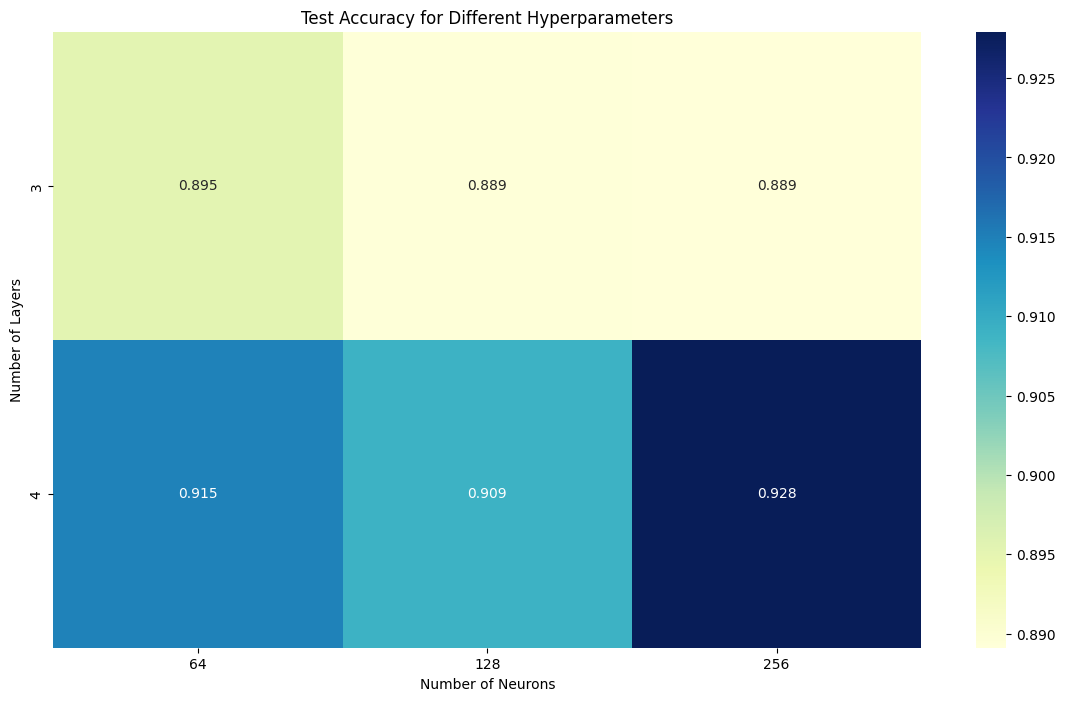

In [13]:
# Convert results to pandas DataFrame for easier manipulation
import pandas as pd
results_df = pd.DataFrame(results)

# Pivot the DataFrame to create a heatmap
pivot_df = results_df.pivot_table(index='num_layers', columns='num_neurons', values='test_accuracy')

# Plotting
plt.figure(figsize=(14, 8))
sns.heatmap(data=pivot_df, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Test Accuracy for Different Hyperparameters')
plt.xlabel('Number of Neurons')
plt.ylabel('Number of Layers')
plt.show()


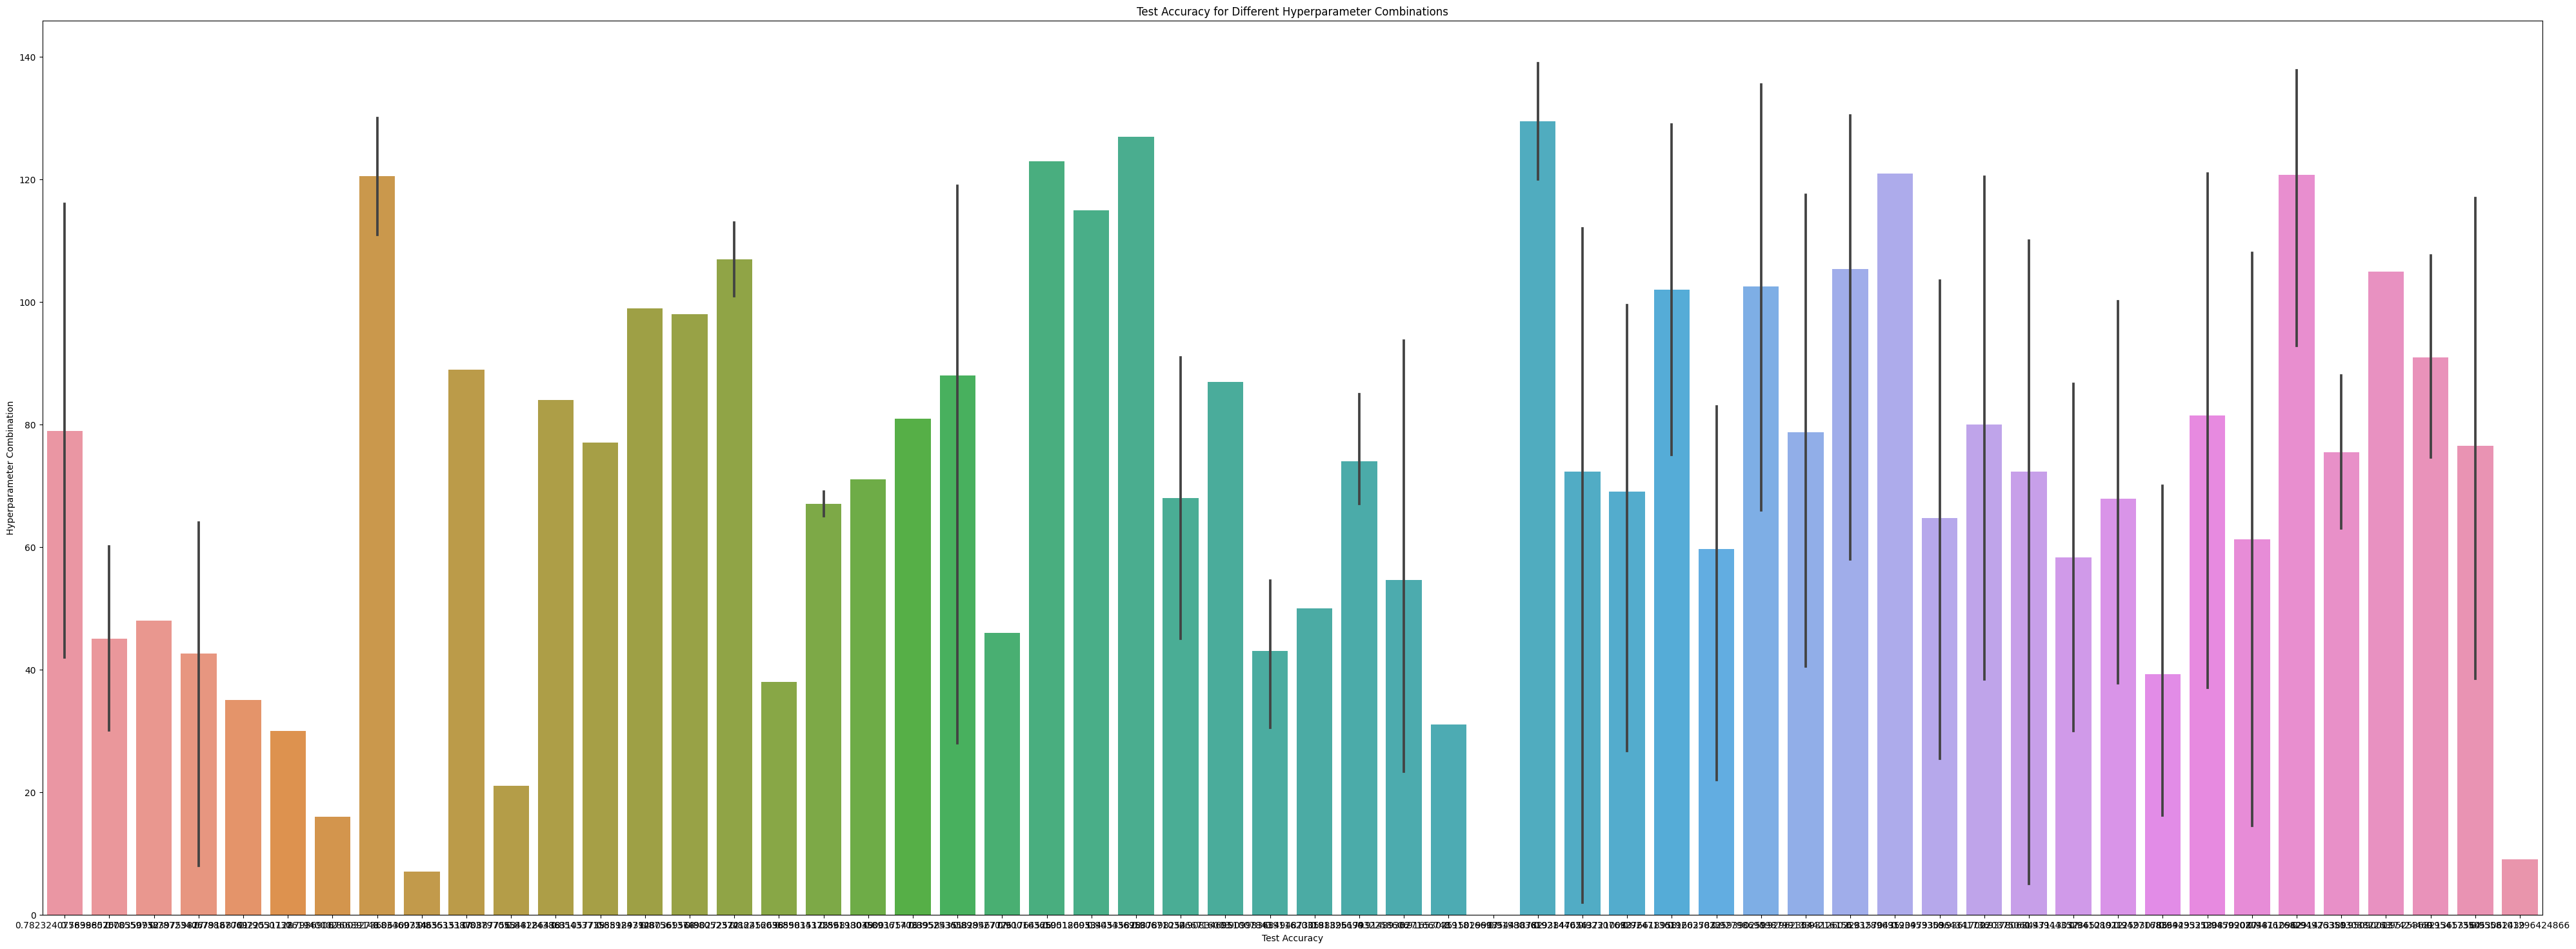

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.8632 - loss: 0.4010 - val_accuracy: 0.8511 - val_loss: 0.4155
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9252 - loss: 0.2480 - val_accuracy: 0.9345 - val_loss: 0.2208
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9192 - loss: 0.2397 - val_accuracy: 0.8543 - val_loss: 0.3814
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9406 - loss: 0.1939 - val_accuracy: 0.9411 - val_loss: 0.2001
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9391 - loss: 0.1864 - val_accuracy: 0.9362 - val_loss: 0.1871
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9503 - loss: 0.1511 - val_accuracy: 0.9149 - val_loss: 0.1968
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9509 - loss: 0.1479 - val_accuracy: 0.8985 - val_loss: 0.2858
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9532 - loss: 0.1499 - val_accuracy: 0.9280 - 

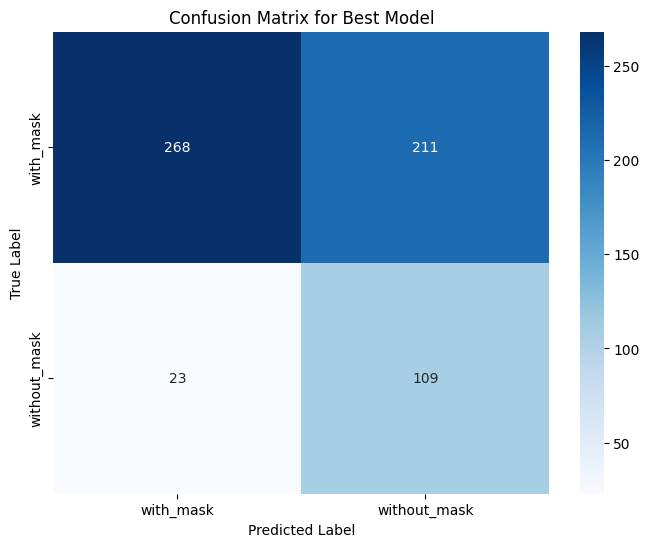

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert results to pandas DataFrame for easier manipulation
import pandas as pd
results_df = pd.DataFrame(results)

# Plot test accuracy for each hyperparameter combination
# Plot test accuracy for each hyperparameter combination
plt.figure(figsize=(50, 18))
sns.barplot(data=results_df, x='test_accuracy', y=results_df.index)
plt.xlabel('Test Accuracy')
plt.ylabel('Hyperparameter Combination')
plt.title('Test Accuracy for Different Hyperparameter Combinations')
plt.show()


# Plot confusion matrix for best hyperparameter combination
best_result = results_df.loc[results_df['test_accuracy'].idxmax()]
best_model = create_cnn_model(best_result['num_layers'], best_result['num_neurons'], best_result['kernel_size'], best_result['dropout_rate'], best_result['regularization_type'], best_result['normalization_type'])
best_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Accuracy: {test_accuracy}")

# Get predictions
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Best Model')
plt.show()


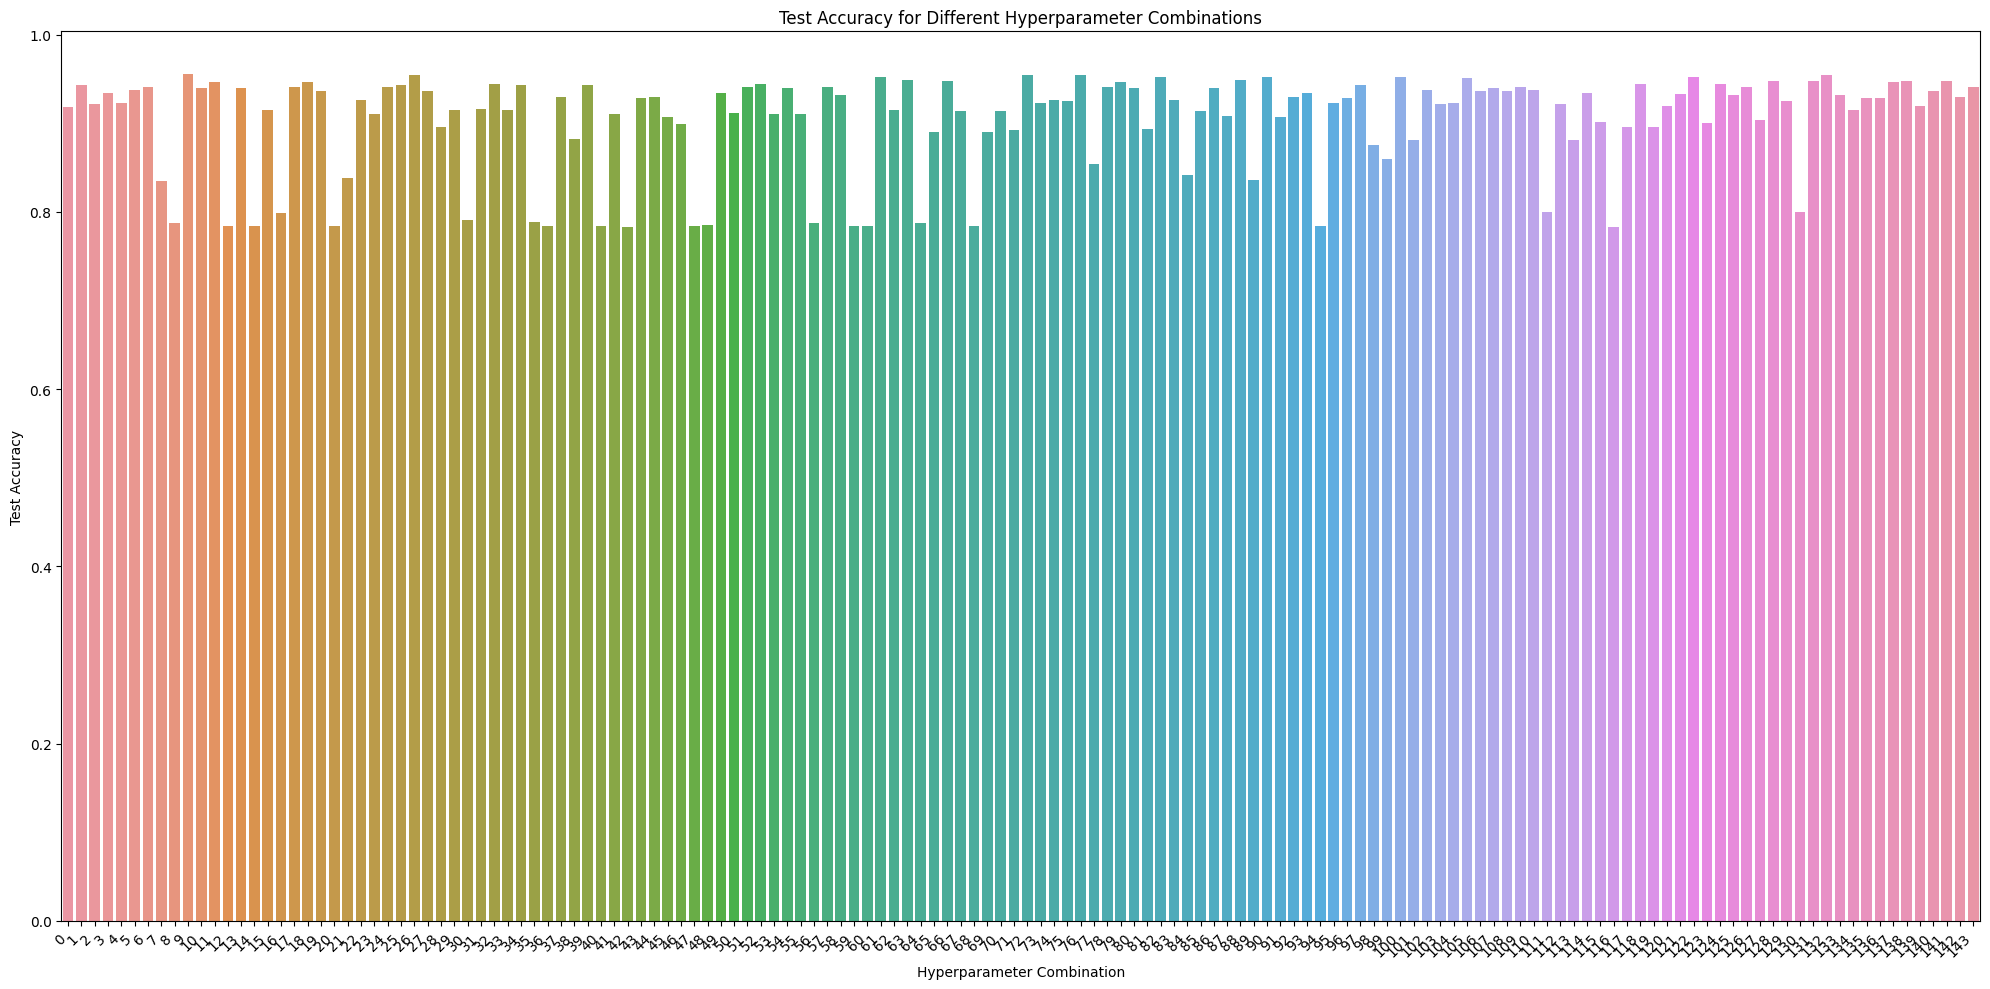

In [34]:
# Plot test accuracy for each hyperparameter combination
plt.figure(figsize=(20, 10))
sns.barplot(data=results_df, y='test_accuracy', x=results_df.index)
plt.ylabel('Test Accuracy')
plt.xlabel('Hyperparameter Combination')
plt.title('Test Accuracy for Different Hyperparameter Combinations')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


/tmp/ipykernel_34/4080689770.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust layout to prevent clipping of labels


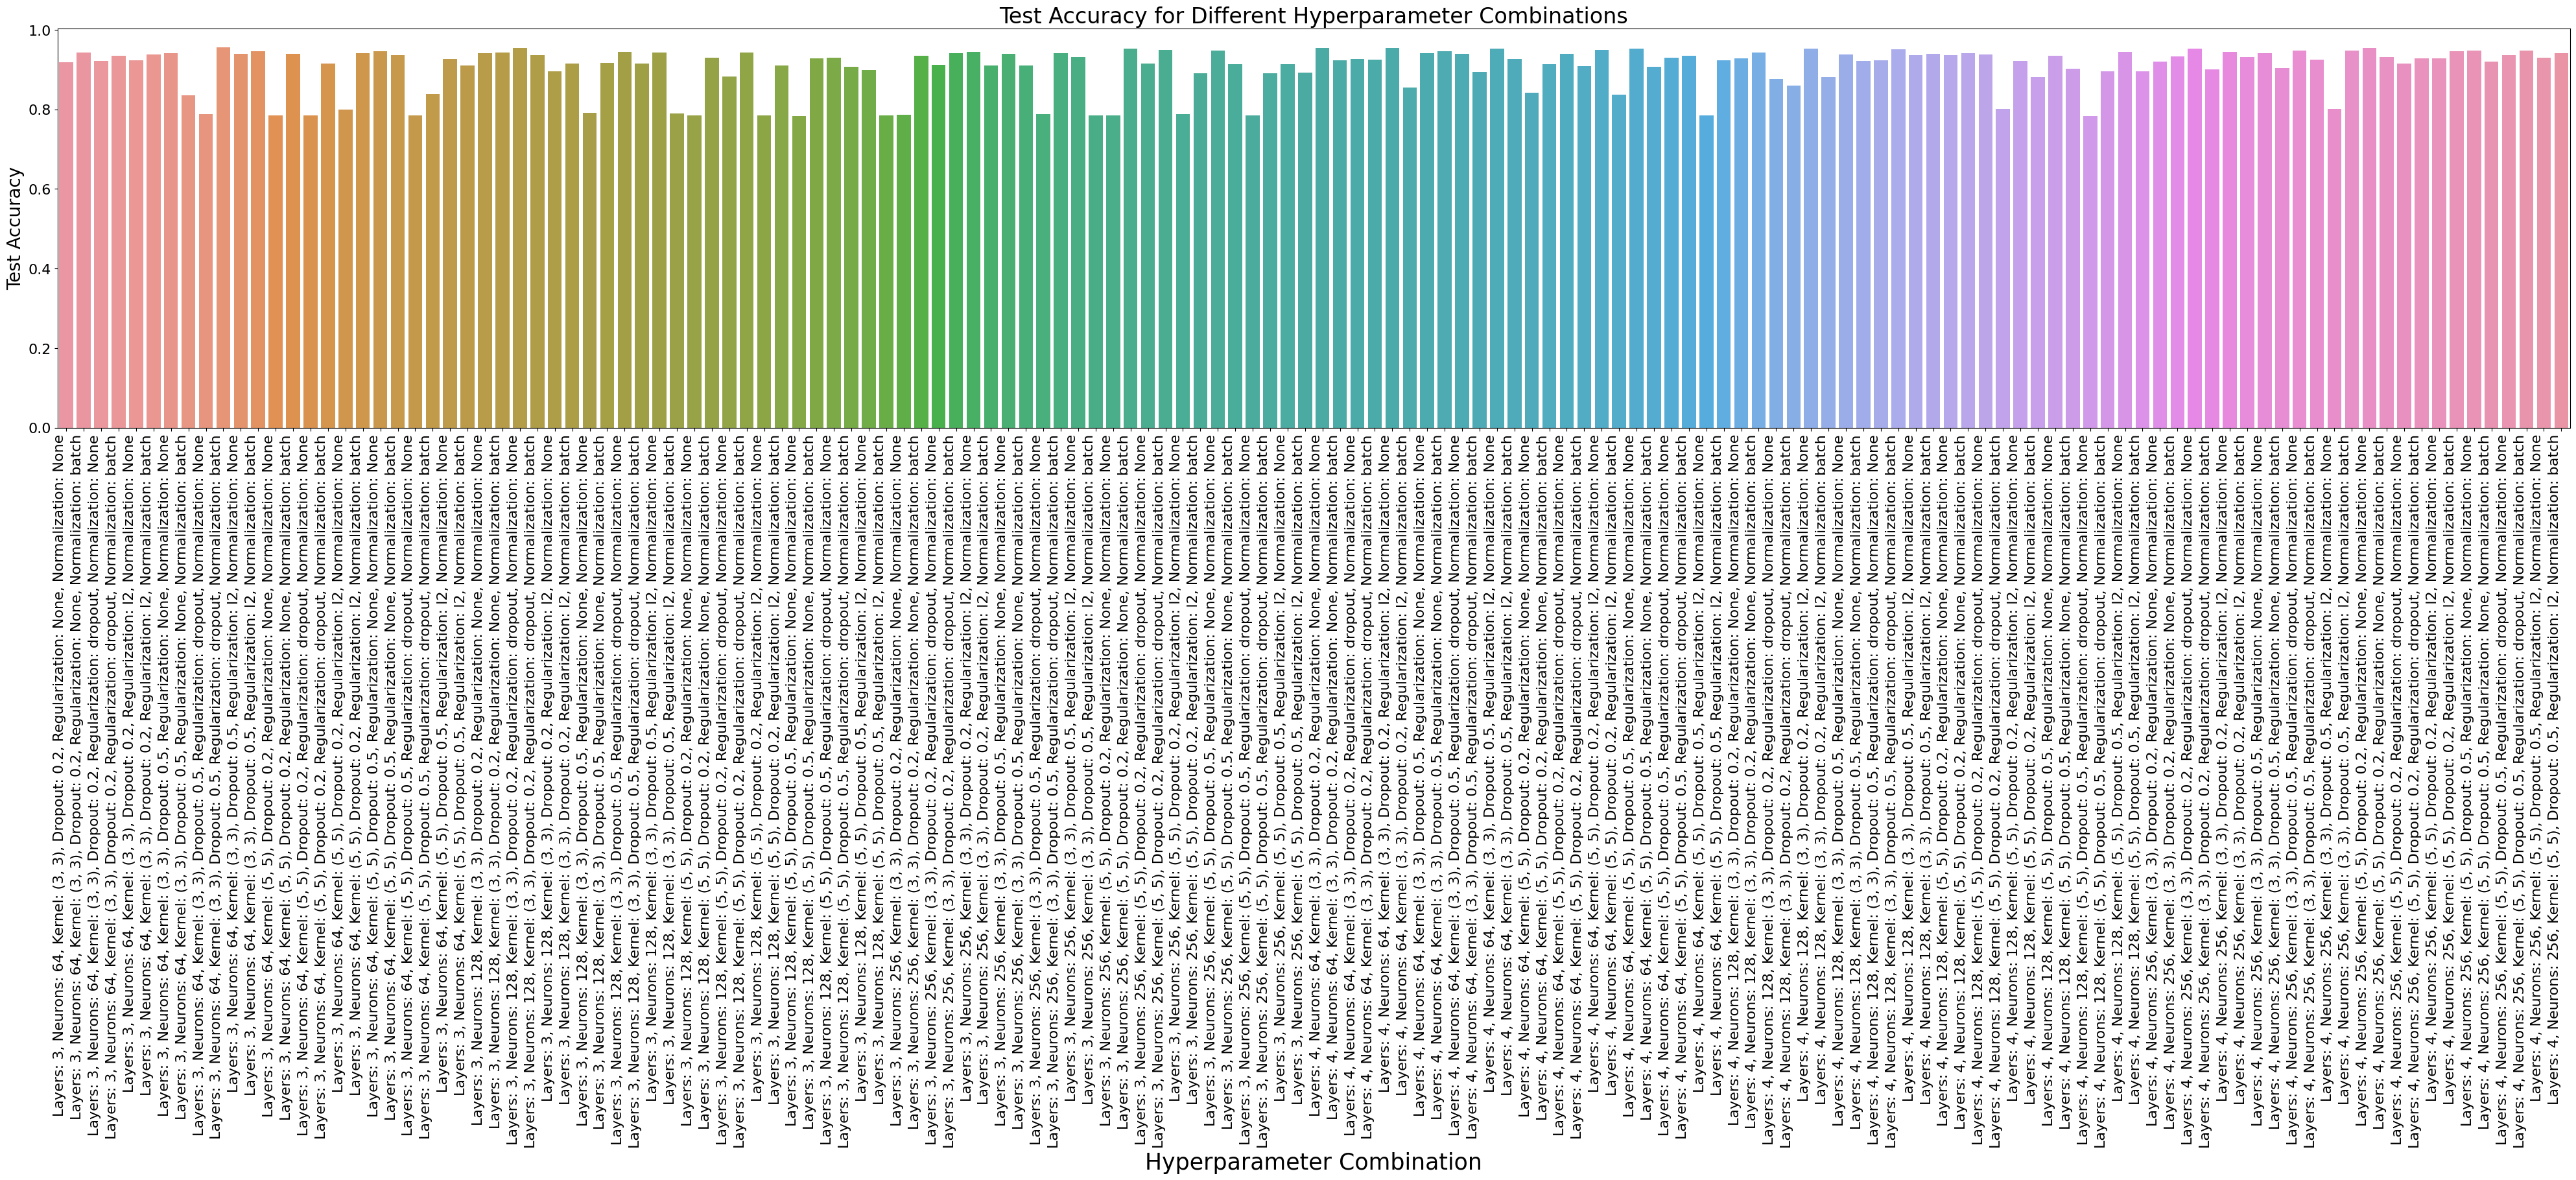

In [45]:
# Convert hyperparameter combination to strings
results_df['Hyperparameter Combination'] = results_df.apply(lambda row: f"Layers: {row['num_layers']}, Neurons: {row['num_neurons']}, Kernel: {row['kernel_size']}, Dropout: {row['dropout_rate']}, Regularization: {row['regularization_type']}, Normalization: {row['normalization_type']}", axis=1)

# Plot test accuracy for each hyperparameter combination
plt.figure(figsize=(50, 8))
sns.barplot(data=results_df, y='test_accuracy', x='Hyperparameter Combination')
plt.ylabel('Test Accuracy', fontsize=20)
plt.xlabel('Hyperparameter Combination', fontsize=25)
plt.title('Test Accuracy for Different Hyperparameter Combinations', fontsize=24)
plt.xticks(rotation=90, ha='right', fontsize=16)  # Rotate x-axis labels and adjust font size
plt.yticks(fontsize=16)  # Adjust font size for y-axis labels
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


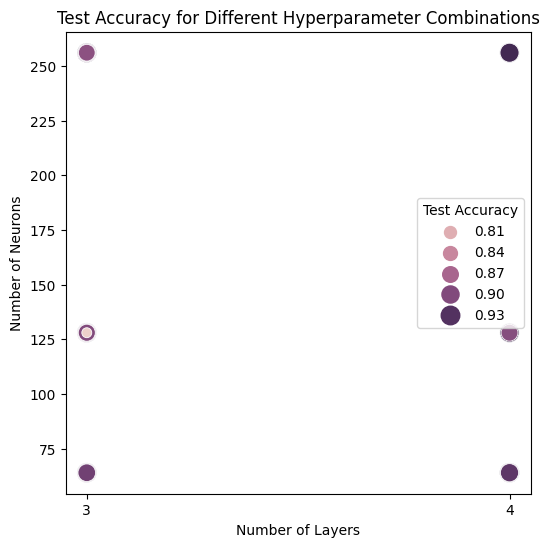

In [46]:
# Plot test accuracy for each hyperparameter combination using a scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(data=results_df, x='num_layers', y='num_neurons', hue='test_accuracy', size='test_accuracy', sizes=(50, 200))
plt.xlabel('Number of Layers')
plt.ylabel('Number of Neurons')
plt.title('Test Accuracy for Different Hyperparameter Combinations')
plt.legend(title='Test Accuracy')
plt.xticks([3, 4])
plt.show()


Best Hyperparameter Combination:
num_layers                    3
num_neurons                  64
kernel_size              (3, 3)
dropout_rate                0.5
regularization_type     dropout
normalization_type        batch
test_loss              0.148337
test_accuracy           0.95581
Name: 9, dtype: object


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.8084 - loss: 0.5292 - val_accuracy: 0.7807 - val_loss: 0.4863
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9147 - loss: 0.2693 - val_accuracy: 0.7987 - val_loss: 0.3987
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9356 - loss: 0.2201 - val_accuracy: 0.9427 - val_loss: 0.1756
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9461 - loss: 0.1615 - val_accuracy: 0.9264 - val_loss: 0.1942
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.9410 - loss: 0.1688 - val_accuracy: 0.9313 - val_loss: 0.2137
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9142 - loss: 0.2230
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


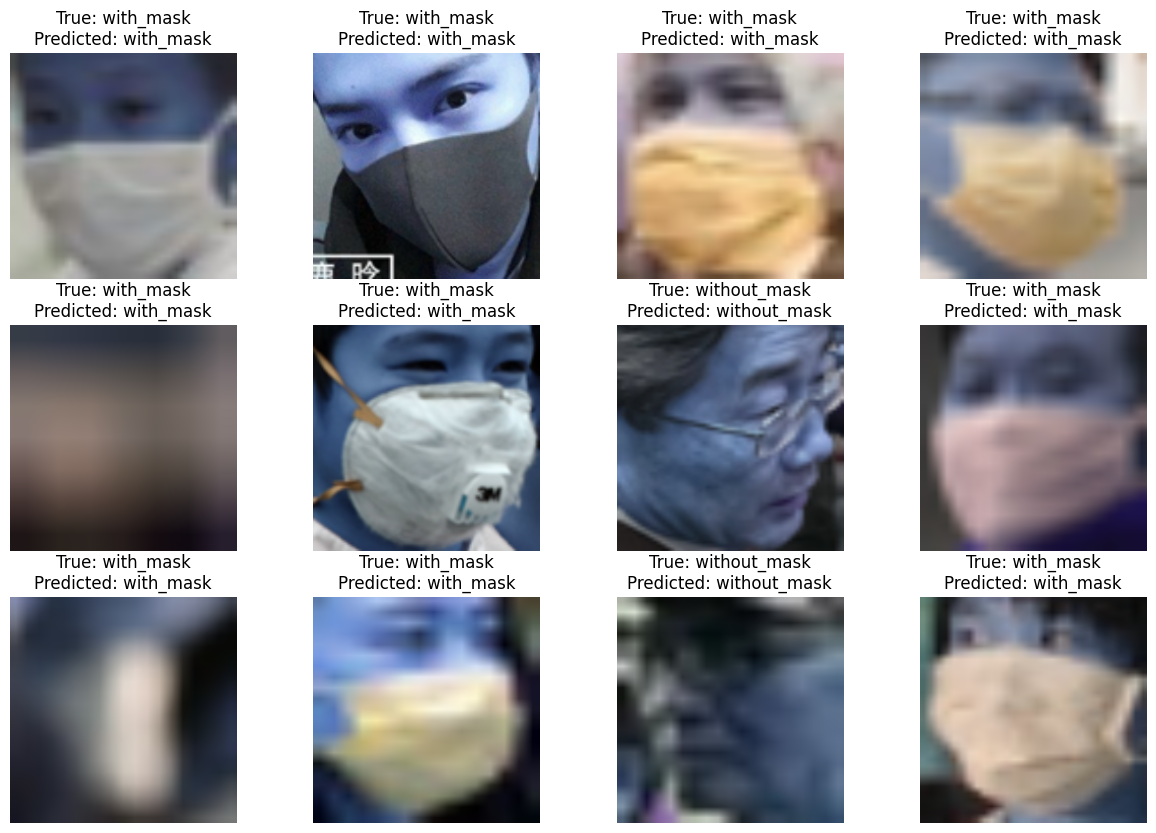

In [47]:
# Convert results to DataFrame for easier manipulation
results_df = pd.DataFrame(results)

# Find the combination with the highest test accuracy
best_combination_idx = results_df['test_accuracy'].idxmax()
best_combination = results_df.loc[best_combination_idx]

# Print the best combination and its test accuracy
print("Best Hyperparameter Combination:")
print(best_combination)

# Use the hyperparameters of the best combination to train a model
best_num_layers = best_combination['num_layers']
best_num_neurons = best_combination['num_neurons']
best_kernel_size = best_combination['kernel_size']
best_dropout_rate = best_combination['dropout_rate']
best_regularization_type = best_combination['regularization_type']
best_normalization_type = best_combination['normalization_type']

# Train and evaluate model with the best combination
best_model = create_cnn_model(best_num_layers, best_num_neurons, best_kernel_size, best_dropout_rate, best_regularization_type, best_normalization_type)
best_history, _, _ = train_and_evaluate(best_model, X_train, y_train, X_val, y_val, X_test, y_test)

# Predict labels for test images using the best model
best_predictions = best_model.predict(X_test[:12])
best_predicted_labels = np.argmax(best_predictions, axis=1)
true_labels = y_test[:12]

# Plot the test images with predicted and true labels
plt.figure(figsize=(15, 10))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(X_test[i])
    plt.title(f"True: {label_encoder.inverse_transform([true_labels[i]])[0]}\nPredicted: {label_encoder.inverse_transform([best_predicted_labels[i]])[0]}")
    plt.axis('off')
plt.show()
